# Installs & Imports

In [ ]:
!pip install optuna -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras import layers, models, utils
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)
import optuna
import random
import os

# Set random seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Loading the Data

In [ ]:
# Load dataset
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data()

# Concatenate train and test sets for analysis
all_reviews = np.concatenate((X_train, X_test))
all_sentiments = np.concatenate((y_train, y_test))

# Calculate total number of words in the dataset
total_words = sum(len(review) for review in all_reviews)
print(f"Total number of words in the dataset: {total_words}")

17464789/17464789 [==============================] - 2s 0us/step
Total number of words in the dataset: 11737946


In [ ]:
# Load the dataset with the 10,000 most common words
num_words=10000

(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)

# Exploring the Data

In [ ]:
# Inspect the data shapes
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}\n")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (25000,)
Shape of y_train: (25000,)

Shape of X_test: (25000,)
Shape of y_test: (25000,)


In [ ]:
# Convert integers to words
word_index = keras.datasets.imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
print(f"The most common word is: {reverse_word_index[1]}")

1641221/1641221 [==============================] - 0s 0us/step
The most common word is: the


In [ ]:
# Print 100 most common tokens
most_common_words = [
    reverse_word_index.get(i - 3, '?') for i in range(3, num_words + 3)
]
print(most_common_words[:100])

['?', 'the', 'and', 'a', 'of', 'to', 'is', 'br', 'in', 'it', 'i', 'this', 'that', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', 'on', 'not', 'you', 'are', 'his', 'have', 'he', 'be', 'one', 'all', 'at', 'by', 'an', 'they', 'who', 'so', 'from', 'like', 'her', 'or', 'just', 'about', "it's", 'out', 'has', 'if', 'some', 'there', 'what', 'good', 'more', 'when', 'very', 'up', 'no', 'time', 'she', 'even', 'my', 'would', 'which', 'only', 'story', 'really', 'see', 'their', 'had', 'can', 'were', 'me', 'well', 'than', 'we', 'much', 'been', 'bad', 'get', 'will', 'do', 'also', 'into', 'people', 'other', 'first', 'great', 'because', 'how', 'him', 'most', "don't", 'made', 'its', 'then', 'way', 'make', 'them', 'too', 'could', 'any', 'movies']


In [ ]:
# Function to decode reviews
def decode_review(text):
    decoded = ' '.join([reverse_word_index.get(i - 3, '?') for i in text])
    return decoded

# Inspect a sample review
print(decode_review(X_train[0]))
print("Label:", "Positive" if y_train[0] == 1 else "Negative")

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

In [ ]:
# Inspect five random reviews
for i in range(5):
    index = np.random.randint(0, len(X_train))
    print(f"Review: {decode_review(X_train[index])}")
    print("Label:", "Positive" if y_train[index] == 1 else "Negative", "\n")

Review: ? amazing movie i saw this movie for the first time on a flight and could not believe that i had not even heard of it before getting on that plane while it may seem at first to be a chick flick it is a film that everyone should see and will enjoy men watch this movie with someone you love you will enjoy it as much as she does and it will score you big points
Label: Positive 

Review: ? i screamed my head off because seeing this movie was my first movie going experience ever at some 13 months old i remember it being incredibly bloody and it made me angry i watched it again on tv a few years ago big mistake the acting is wooden the plot non existent and the movie lacks merit unless 23 year old t a is what gets you going 0
Label: Negative 

Review: ? lets make a movie about a talk show that already exists and basically have everything that happens on the show well if that idea doesn't intrigue you which it shouldn't stay away from ? i had the ? of seeing this in the theater and ac

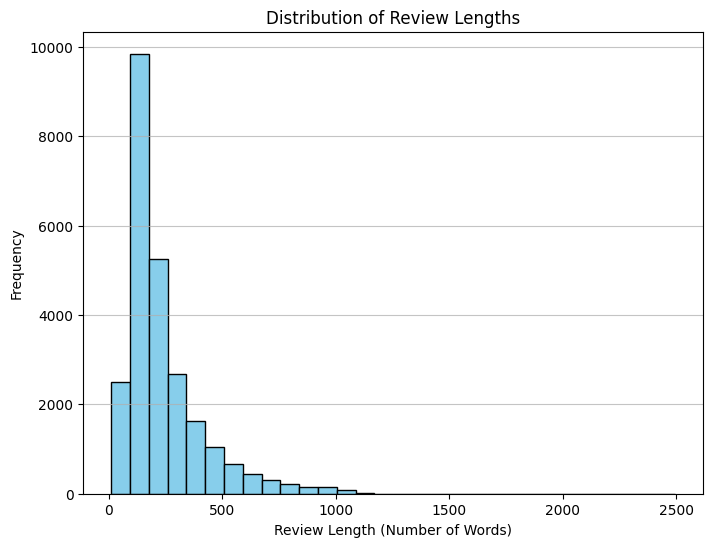

In [ ]:
# Visualize length distribution
review_lengths = [len(review) for review in X_train]
plt.figure(figsize=(8, 6))
plt.hist(review_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Review Lengths")
plt.xlabel("Review Length (Number of Words)")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.show()

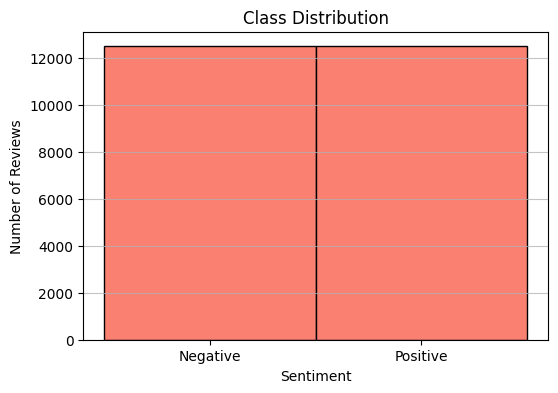

In [ ]:
# Visualize class distribution
plt.figure(figsize=(6, 4))
plt.hist(y_train, bins=[-0.5, 0.5, 1.5], color='salmon', edgecolor='black')
plt.title("Class Distribution")
plt.xticks([0, 1], ["Negative", "Positive"])
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.grid(axis='y', alpha=0.75)
plt.show()

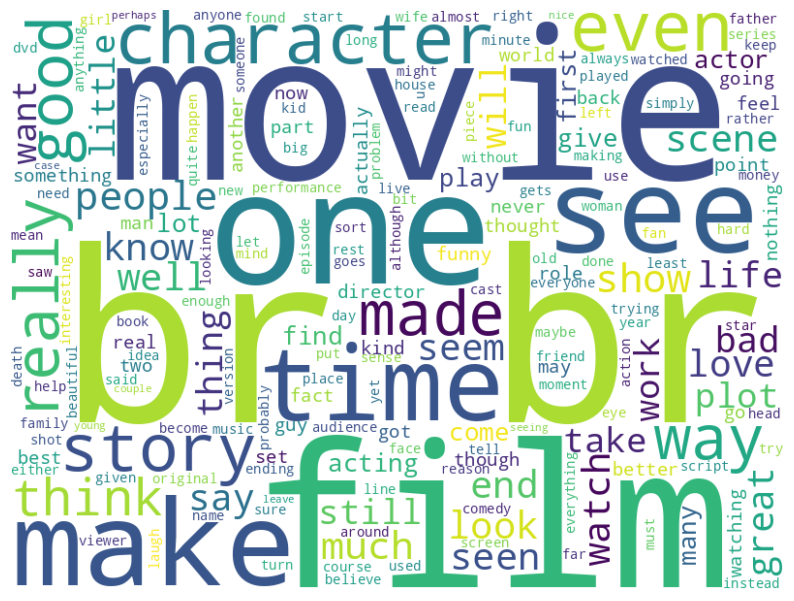

In [ ]:
from wordcloud import WordCloud

# Function to create the word cloud
def create_word_cloud(text):
    wc = WordCloud(background_color="white", width=800, height=600)
    wc.generate(text)
    return wc

decoded_reviews = [' '.join(
    [reverse_word_index.get(i - 3, '?') for i in review]
) for review in X_train]

combined_reviews = " ".join(decoded_reviews)
word_cloud = create_word_cloud(combined_reviews)

# Display the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Preprocessing the Data

## Splitting the Data

In [ ]:
# Split the test data into validation and test sets
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test,
    test_size=0.5,
    stratify=y_test,
    random_state=42
)

In [ ]:
# Shuffle the training set
np.random.seed(SEED)
indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)

X_train = X_train[indices]
y_train = y_train[indices]

In [ ]:
# Check the partition shapes
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}\n")

print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}\n")

print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (25000,)
y_train: (25000,)

X_val: (12500,)
y_val: (12500,)

X_test: (12500,)
y_test: (12500,)


In [ ]:
# Check the class balances
print(f"y_train: {np.bincount(y_train)}")
print(f"y_val: {np.bincount(y_val)}")
print(f"y_test: {np.bincount(y_test)}")

y_train: [12500 12500]
y_val: [6250 6250]
y_test: [6250 6250]


## Bag of Words

In [ ]:
# Prepare data with Bag of Words approach
vectorizer_bow = CountVectorizer(max_features=num_words)

X_train_bow = vectorizer_bow.fit_transform(
    [decode_review(review) for review in X_train]
).toarray()

X_val_bow = vectorizer_bow.transform(
    [decode_review(review) for review in X_val]
).toarray()

X_test_bow = vectorizer_bow.transform(
    [decode_review(review) for review in X_test]
).toarray()

In [ ]:
# Examine BoW transformation
print(f"Original Review: {decode_review(X_train[0])}")
print(f"BoW Transformed Review: {X_train_bow[0]}")  # Sparse with lots of 0s

Original Review: ? there's a major difference between releasing an original intense edge of your seat scary gore fest and doing like filmmaker eli roth and his team have done with cabin fever and simply acted like it the film follows five college ? into a cabin in the woods that begins to prove fatal as one after the other ? to this mysterious fast acting flesh eating disease it's not long before the friends turn on one another and can barely stand the sight of one another much less want to be in the same ? as them as gross as it all sounds there's a certain spark behind the basic premise of this film that could have worked in the hands of a less cocky filmmaker unfortunately what we end up with is poorly drawn characters whose sole purpose seems to be to look beautiful at the beginning to make the inevitable ? more ? a hackneyed script so profanity laden as to leave the viewer ? out the dialogue and several incomprehensible subplots that ? little more than in one instance an on screen

## TF-IDF

In [ ]:
# Prepare the data with TF-IDF approach
vectorizer_tfidf = TfidfVectorizer(max_features=num_words)

X_train_tfidf = vectorizer_tfidf.fit_transform(
    [decode_review(review) for review in X_train]
).toarray()

X_val_tfidf = vectorizer_tfidf.transform(
    [decode_review(review) for review in X_val]
).toarray()

X_test_tfidf = vectorizer_tfidf.transform(
    [decode_review(review) for review in X_test]
).toarray()

In [ ]:
# Examine TF-IDF transformation
print(f"Original Review: {decode_review(X_train[0])}")
print(f"TF-IDF Transformed Review: {X_train_tfidf[0]}")  # Sparse with lots of 0s

Original Review: ? there's a major difference between releasing an original intense edge of your seat scary gore fest and doing like filmmaker eli roth and his team have done with cabin fever and simply acted like it the film follows five college ? into a cabin in the woods that begins to prove fatal as one after the other ? to this mysterious fast acting flesh eating disease it's not long before the friends turn on one another and can barely stand the sight of one another much less want to be in the same ? as them as gross as it all sounds there's a certain spark behind the basic premise of this film that could have worked in the hands of a less cocky filmmaker unfortunately what we end up with is poorly drawn characters whose sole purpose seems to be to look beautiful at the beginning to make the inevitable ? more ? a hackneyed script so profanity laden as to leave the viewer ? out the dialogue and several incomprehensible subplots that ? little more than in one instance an on screen

## Dimensionality Reduction

In [ ]:
from sklearn.decomposition import TruncatedSVD

# Number of components to keep
n_components = 100
svd = TruncatedSVD(n_components=n_components)

# Reduce dimensionality for SVM model inputs - BoW
X_train_bow_svd = svd.fit_transform(X_train_bow)
X_val_bow_svd = svd.transform(X_val_bow)
X_test_bow_svd = svd.transform(X_test_bow)

# Reduce dimensionality for SVM model inputs - TF-IDF
X_train_tfidf_svd = svd.fit_transform(X_train_tfidf)
X_val_tfidf_svd = svd.transform(X_val_tfidf)
X_test_tfidf_svd = svd.transform(X_test_tfidf)

## Padding

In [ ]:
# Set max word length for reviews
maxlen = 250

# Pad the sequences for the neural network models
X_train_pad = pad_sequences(X_train, maxlen=maxlen)
X_val_pad = pad_sequences(X_val, maxlen=maxlen)
X_test_pad = pad_sequences(X_test, maxlen=maxlen)

In [ ]:
# Examine a padded sequence
print(f"Original Review (first 20 words): {X_train[0][:20]}")
print(f"Padded Sequence: {X_train_pad[0]}")

Original Review (first 20 words): [1, 225, 6, 678, 1474, 200, 7018, 35, 204, 1596, 1289, 7, 129, 2224, 629, 599, 3340, 5, 399, 40]
Padded Sequence: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    1  225    6  678 1474  200 7018
   35  204 1596 1289    7  129 2224  629  599 3340    5  399   40 1723
 7462 4915    5   27  768   28  224   19 2816 3812    5  331  917   40
   12    4   22 1160  677 1170    2   83    6 2816   11    4 1411   15
  778    8 1970 3610   17   31  103    4   85    2    8   14 1397  702
  116 2120 1889 3497   45   24  196  159    4  369  471   23   31  160
    5   70 1201  759    4 1682    7   31  160   76  329  181    8   30
   11    4  172    2   17   98   17 2742   17   12   32  934  225    6
  813 5371  496    4 1121  863    7   14   22   15  100   28  952   11


# Modeling Phase

## Utility Functions

### Metrics DataFrame Function

In [ ]:
# Function to get metrics DataFrame
def get_model_metrics(model, X, y, model_type="ml"):
    # Get predictions
    if model_type == "ml":
        y_pred = model.predict(X)
        try:
            y_pred_proba = model.predict(X)
        except:
            y_pred_proba = None
    elif model_type == "dl":
        y_pred = (model.predict(X) > 0.5).astype("int32")
        y_pred_proba = model.predict(X)

    # Calculate metrics
    metrics = {
        "Accuracy": accuracy_score(y, y_pred),
        "Precision": precision_score(y, y_pred),
        "Recall": recall_score(y, y_pred),
        "F1 Score": f1_score(y, y_pred)
    }

    if y_pred_proba is not None:
        try:
            metrics["ROC-AUC"] = roc_auc_score(y, y_pred_proba[:, 1])
        except IndexError:
            metrics["ROC-AUC"] = roc_auc_score(y, y_pred_proba)

    # Create DataFrame
    metrics_df = pd.DataFrame.from_dict(metrics, orient="index", columns=["Score"])
    return metrics_df

### Training Callbacks Function

In [ ]:
# Function to create callbacks
def create_callbacks(verbose=1, early_stopping_patience=5, reduce_lr_patience=2):
    # Early stopping
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=early_stopping_patience,
        restore_best_weights=True,
        verbose=verbose
    )

    # Reduce LR on plateau
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.1,
        patience=reduce_lr_patience,
        verbose=verbose,
        min_delta=1e-2,
        mode="min"
    )

    return [early_stopping, reduce_lr]

### History Plotting Function

In [ ]:
# Function to visualize training history
def plot_training_history(history):
    # Dynamically determine the number of epochs
    epochs_range = range(1, len(history.history["loss"]) + 1)

    # Plot losses
    plt.figure(figsize=(15, 6))
    plt.plot(epochs_range, history.history.get("loss", []), label="Train Loss")
    plt.plot(epochs_range, history.history.get("val_loss", []), label="Validation Loss")
    plt.title("Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plot accuracies
    plt.figure(figsize=(15, 6))
    if "accuracy" in history.history:
        plt.plot(epochs_range, history.history["accuracy"], label="Train Accuracy")
    if "val_accuracy" in history.history:
        plt.plot(epochs_range, history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

### Comparison Plotting Function

In [ ]:
# Function to create plots from a dictionary of metrics DataFrames
def compare_model_performance(metrics_dict):
    # Combine all DataFrames into one
    combined_df = pd.DataFrame()
    for model_name, metrics_df in metrics_dict.items():
        # Transpose and rename for clarity
        temp_df = metrics_df.transpose()
        temp_df["Model"] = model_name
        combined_df = pd.concat([combined_df, temp_df], ignore_index=True)

    # Melt the DataFrame for seaborn compatibility
    melted_df = combined_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

    # Plot
    plt.figure(figsize=(12, 6))
    barplot = sns.barplot(x="Metric", y="Score", hue="Model", data=melted_df, palette="pastel")

    # Move the legend outside the plot
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")

    # Annotate the bars with scores
    for p in barplot.patches:
        if p.get_height() > 0.001:
            barplot.annotate(format(p.get_height(), '.3f'),
                            (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha="center", va="center",
                            xytext=(0, 9),
                            textcoords="offset points",
                            fontsize=9,
                            rotation=45)

    plt.title("Model Performance Comparison")
    plt.ylabel("Score")
    plt.xlabel("Metric")
    plt.tight_layout()
    plt.show()

## Training Parameters

In [ ]:
# Set epochs and batch size
EPOCHS = 12
BATCH_SIZE = 64

## Clear Session

In [ ]:
# Clear the session for Keras models if necessary
keras.backend.clear_session()

## Random Forest

### BoW

In [ ]:
# Random forest - BoW
rf_bow = RandomForestClassifier(n_estimators=100, random_state=42)
rf_bow.fit(X_train_bow, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Get metrics - BoW
get_model_metrics(rf_bow, X_val_bow, y_val, model_type="ml")

,Score
Accuracy,0.849360
Precision,0.849752
Recall,0.848800
F1 Score,0.849276
ROC-AUC,0.849360


### TF-IDF

In [ ]:
# Random forest - TF-IDF
rf_tfidf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_tfidf.fit(X_train_tfidf, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Get metrics - TF-IDF
get_model_metrics(rf_tfidf, X_val_tfidf, y_val, model_type="ml")

,Score
Accuracy,0.843200
Precision,0.855015
Recall,0.826560
F1 Score,0.840547
ROC-AUC,0.843200


## Support Vector Machine

### BoW

In [ ]:
# Support vector machine - BoW
svm_bow = SVC(kernel="rbf", probability=True, random_state=42)
svm_bow.fit(X_train_bow_svd, y_train)

SVC(probability=True, random_state=42)

In [ ]:
# Get metrics - BoW
get_model_metrics(svm_bow, X_val_bow_svd, y_val, model_type="ml")

,Score
Accuracy,0.783120
Precision,0.775409
Recall,0.797120
F1 Score,0.786114
ROC-AUC,0.783120


### TF-IDF

In [ ]:
# Support vector machine - TF-IDF
svm_tfidf = SVC(kernel="rbf", probability=True, random_state=42)
svm_tfidf.fit(X_train_tfidf_svd, y_train)

SVC(probability=True, random_state=42)

In [ ]:
# Get metrics - TF-IDF
get_model_metrics(svm_tfidf, X_val_tfidf_svd, y_val, model_type="ml")

,Score
Accuracy,0.850880
Precision,0.848095
Recall,0.854880
F1 Score,0.851474
ROC-AUC,0.850880


## Convolutional Neural Network

In [ ]:
# Function for the residual blocks
def residual_block_cnn(x, filters, kernel_size):
    # Create regularizer
    l2_reg = keras.regularizers.l2(0.01)

    # Start of residual block
    shortcut = x

    # First convolutional block
    x = layers.Conv1D(filters, kernel_size, padding="same", kernel_regularizer=l2_reg, kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Second convolutional block
    x = layers.Conv1D(filters, kernel_size, padding="same", kernel_regularizer=l2_reg, kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)

    # Convolutional shortcut to match dimensions
    if x.shape[-1] != shortcut.shape[-1]:
        shortcut = layers.Conv1D(filters, 1, padding="same", kernel_regularizer=l2_reg, kernel_initializer="he_normal")(shortcut)

    # Add the shortcut
    x = layers.Add()([x, shortcut])
    x = layers.Activation("relu")(x)

    return x

In [ ]:
# Function to build the CNN model
def build_cnn_model(input_dim, embedding_dim, maxlen, num_blocks):
    # Input layer
    input_layer = layers.Input(shape=(maxlen,))

    # Embedding layer
    x = layers.Embedding(input_dim, embedding_dim)(input_layer)

    # Residual blocks
    for _ in range(num_blocks):
        x = residual_block_cnn(x, 16, 3)

    # Reduce dimensions
    x = layers.GlobalMaxPooling1D()(x)

    # Dense layer
    x = layers.Dense(16, activation="relu")(x)

    # Dropout layer
    x = layers.Dropout(0.7)(x)

    # Output layer
    output_layer = layers.Dense(1, activation="sigmoid")(x)

    # Create the model
    model = keras.Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [ ]:
# Set function arguments
embedding_dim = 16
num_blocks = 2

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 250)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 250, 16)              160000    ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 250, 16)              784       ['embedding[0][0]']           
                                                                                                  
 batch_normalization (Batch  (None, 250, 16)              64        ['conv1d[0][0]']              
 Normalization)                                                                               

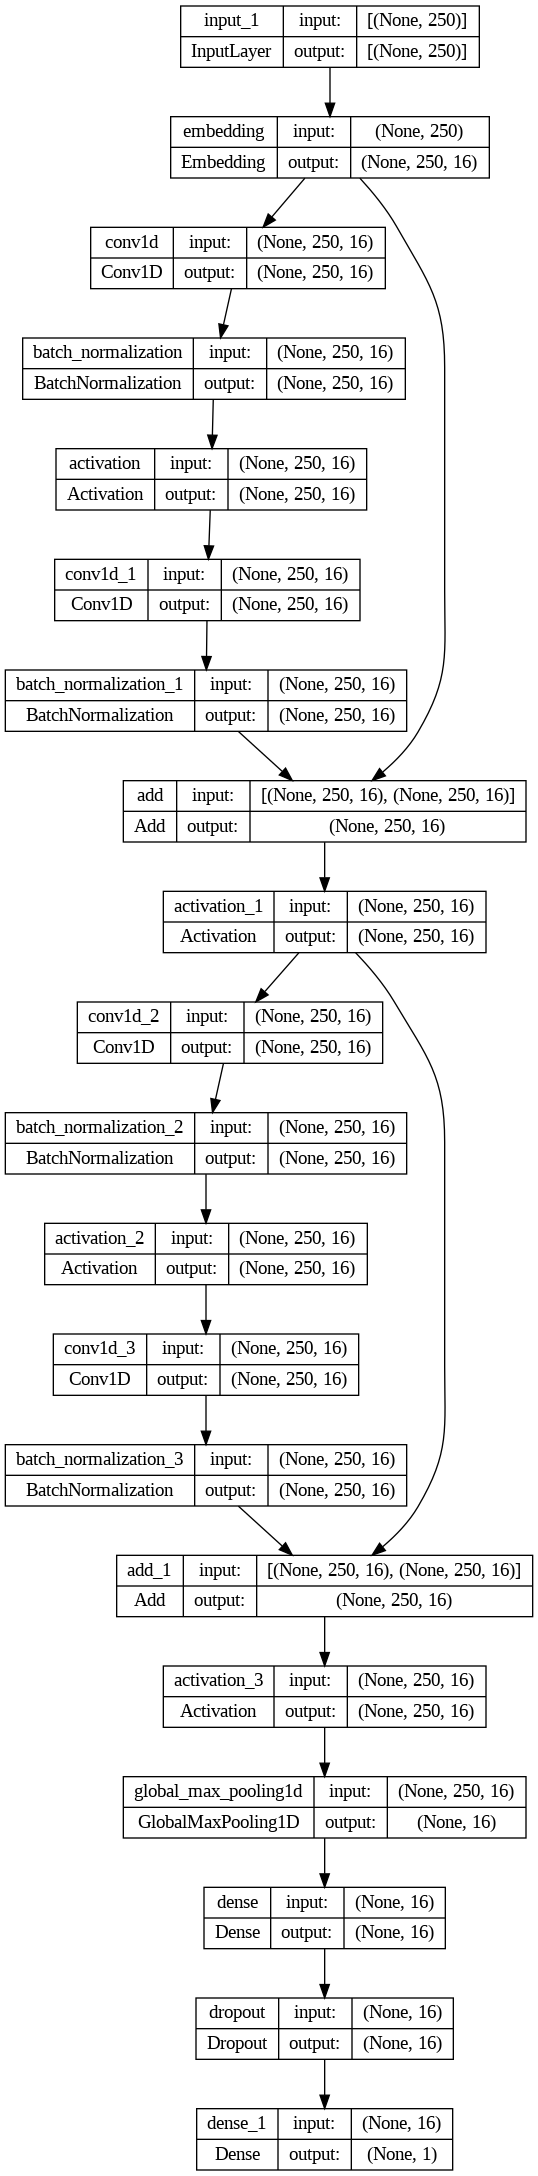

In [ ]:
# Build the model
cnn_model = build_cnn_model(num_words, embedding_dim, maxlen, num_blocks)

# Get model summary
cnn_model.summary()

# Plot the model
utils.plot_model(cnn_model, show_shapes=True)

In [ ]:
# Train the model
cnn_history = cnn_model.fit(
    X_train_pad, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_pad, y_val),
    callbacks=create_callbacks()
)

Epoch 1/12
391/391 [==============================] - 44s 94ms/step - loss: 1.8596 - accuracy: 0.5241 - val_loss: 1.6284 - val_accuracy: 0.5001 - lr: 0.0010
Epoch 2/12
391/391 [==============================] - 16s 42ms/step - loss: 1.1439 - accuracy: 0.6042 - val_loss: 0.9536 - val_accuracy: 0.6720 - lr: 0.0010
Epoch 3/12
391/391 [==============================] - 8s 22ms/step - loss: 0.8126 - accuracy: 0.6802 - val_loss: 0.6664 - val_accuracy: 0.7730 - lr: 0.0010
Epoch 4/12
391/391 [==============================] - 8s 21ms/step - loss: 0.6235 - accuracy: 0.7410 - val_loss: 0.5408 - val_accuracy: 0.8135 - lr: 0.0010
Epoch 5/12
391/391 [==============================] - 9s 22ms/step - loss: 0.5084 - accuracy: 0.7969 - val_loss: 0.4759 - val_accuracy: 0.8190 - lr: 0.0010
Epoch 6/12
391/391 [==============================] - 5s 13ms/step - loss: 0.4303 - accuracy: 0.8253 - val_loss: 0.4335 - val_accuracy: 0.8361 - lr: 0.0010
Epoch 7/12
391/391 [==============================] - 6s 15ms/

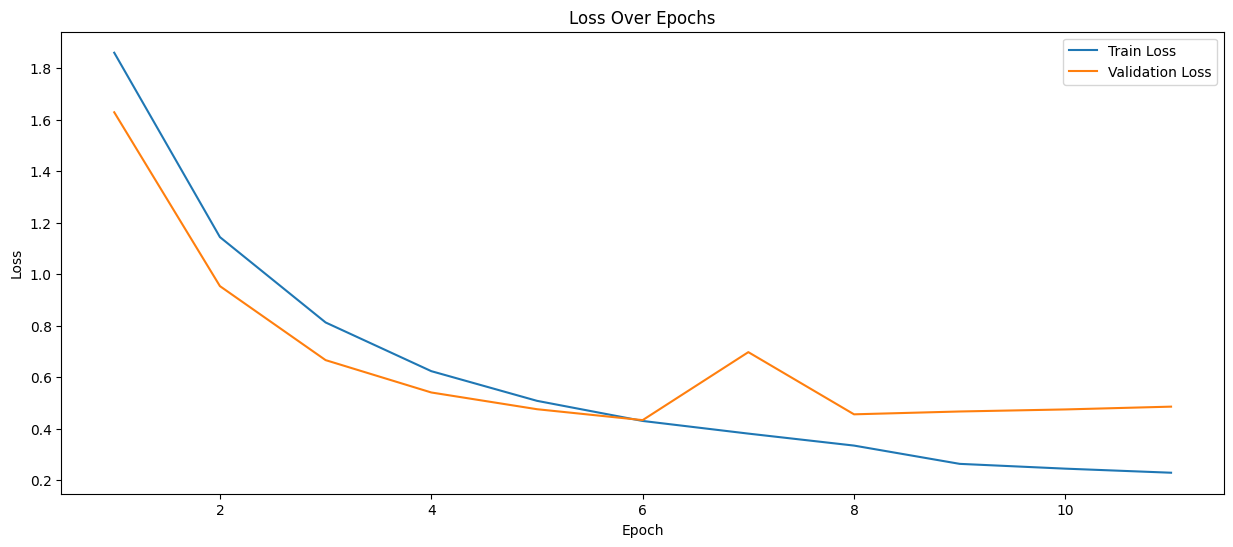

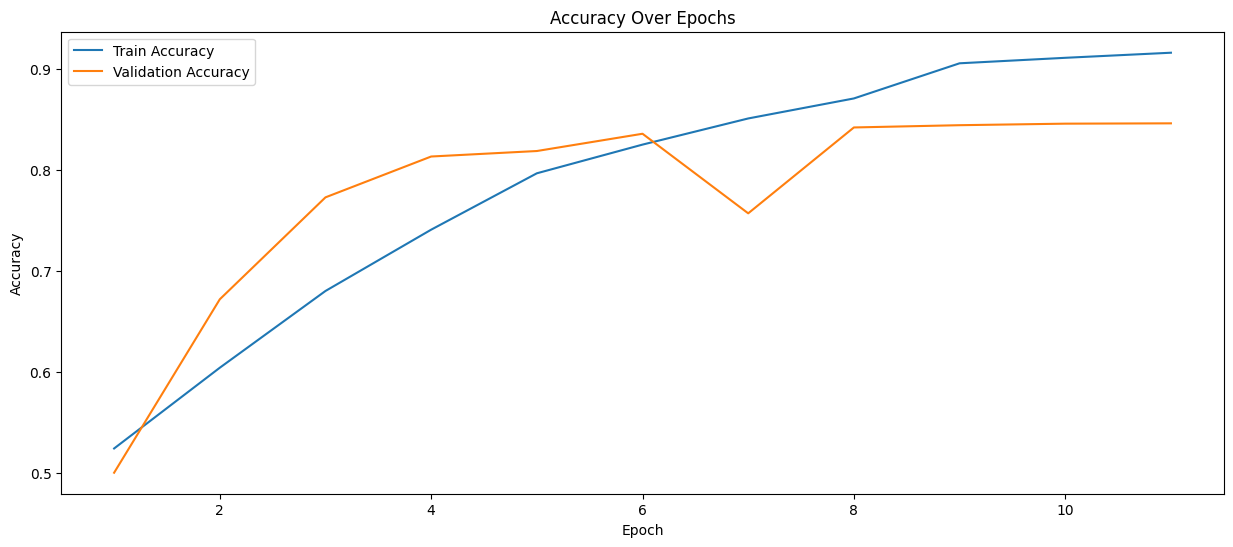

In [ ]:
# Visualize the training history
plot_training_history(cnn_history)

In [ ]:
# Get metrics
get_model_metrics(cnn_model, X_val_pad, y_val, model_type="dl")

391/391 [==============================] - 1s 2ms/step


,Score
Accuracy,0.836080
Precision,0.847938
Recall,0.819040
F1 Score,0.833238
ROC-AUC,0.916453


## LSTM Neural Network

### Skip Connections

In [ ]:
# Function for the skip blocks
def skip_block_lstm(x, units):
    # LSTM layer
    lstm_out = layers.LSTM(units, return_sequences=True, dropout=0.2)(x)

    # Normalizing the LSTM output
    norm_out = layers.LayerNormalization()(lstm_out)

    # Convolution to match dimensions if necessary
    if x.shape[-1] != units:
        x = layers.Conv1D(units, 1)(x)

    # Concatenate original input and LSTM output
    x = layers.Concatenate()([x, norm_out])

    return x

In [ ]:
# Function to build the LSTM model
def build_skip_lstm_model(input_dim, embedding_dim, maxlen, num_blocks, lstm_units):
    # Input layer
    input_layer = layers.Input(shape=(maxlen,))

    # Embedding layer
    x = layers.Embedding(input_dim, embedding_dim)(input_layer)

    # Skip blocks
    for _ in range(num_blocks):
        x = skip_block_lstm(x, lstm_units)

    # Final LSTM layer
    x = layers.LSTM(lstm_units, return_sequences=False, dropout=0.2)(x)

    # Dense layer
    x = layers.Dense(16, activation="relu")(x)

    # Dropout layer
    x = layers.Dropout(0.5)(x)

    # Output layer
    output_layer = layers.Dense(1, activation="sigmoid")(x)

    # Create the model
    model = models.Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 250)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 250, 16)              160000    ['input_2[0][0]']             
                                                                                                  
 lstm (LSTM)                 (None, 250, 16)              2112      ['embedding_1[0][0]']         
                                                                                                  
 layer_normalization (Layer  (None, 250, 16)              32        ['lstm[0][0]']                
 Normalization)                                                                             

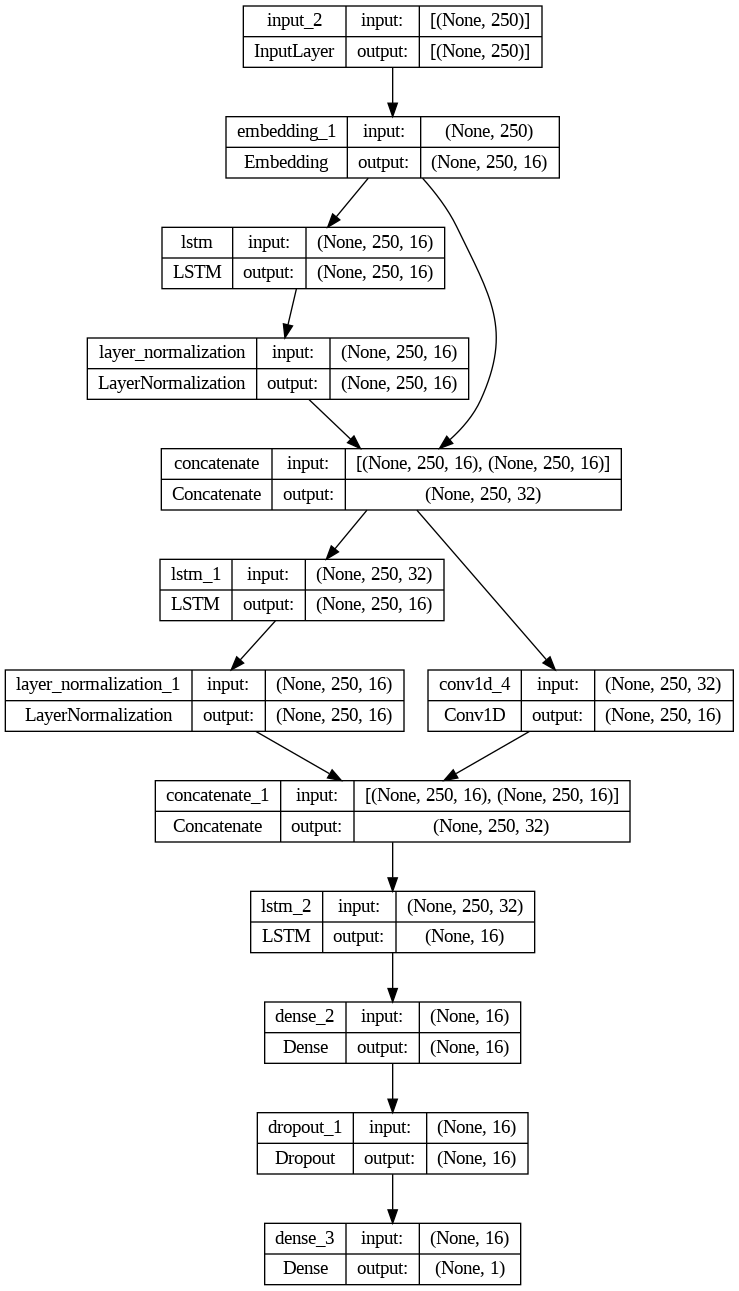

In [ ]:
# Build the model
lstm_skip = build_skip_lstm_model(num_words, embedding_dim, maxlen, num_blocks, 16)

# Get model summary
lstm_skip.summary()

# Plot the model
utils.plot_model(lstm_skip, show_shapes=True)

In [ ]:
# Train the model
lstm_skip_history = lstm_skip.fit(
    X_train_pad, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_pad, y_val),
    callbacks=create_callbacks()
)

Epoch 1/12
391/391 [==============================] - 39s 84ms/step - loss: 0.5467 - accuracy: 0.7225 - val_loss: 0.3744 - val_accuracy: 0.8376 - lr: 0.0010
Epoch 2/12
391/391 [==============================] - 19s 48ms/step - loss: 0.3797 - accuracy: 0.8469 - val_loss: 0.3690 - val_accuracy: 0.8397 - lr: 0.0010
Epoch 3/12
391/391 [==============================] - 14s 37ms/step - loss: 0.2877 - accuracy: 0.8968 - val_loss: 0.3207 - val_accuracy: 0.8690 - lr: 0.0010
Epoch 4/12
391/391 [==============================] - 14s 36ms/step - loss: 0.2336 - accuracy: 0.9205 - val_loss: 0.3387 - val_accuracy: 0.8576 - lr: 0.0010
Epoch 5/12
391/391 [==============================] - ETA: 0s - loss: 0.1897 - accuracy: 0.9395
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
391/391 [==============================] - 14s 36ms/step - loss: 0.1897 - accuracy: 0.9395 - val_loss: 0.3430 - val_accuracy: 0.8707 - lr: 0.0010
Epoch 6/12
391/391 [==============================] -

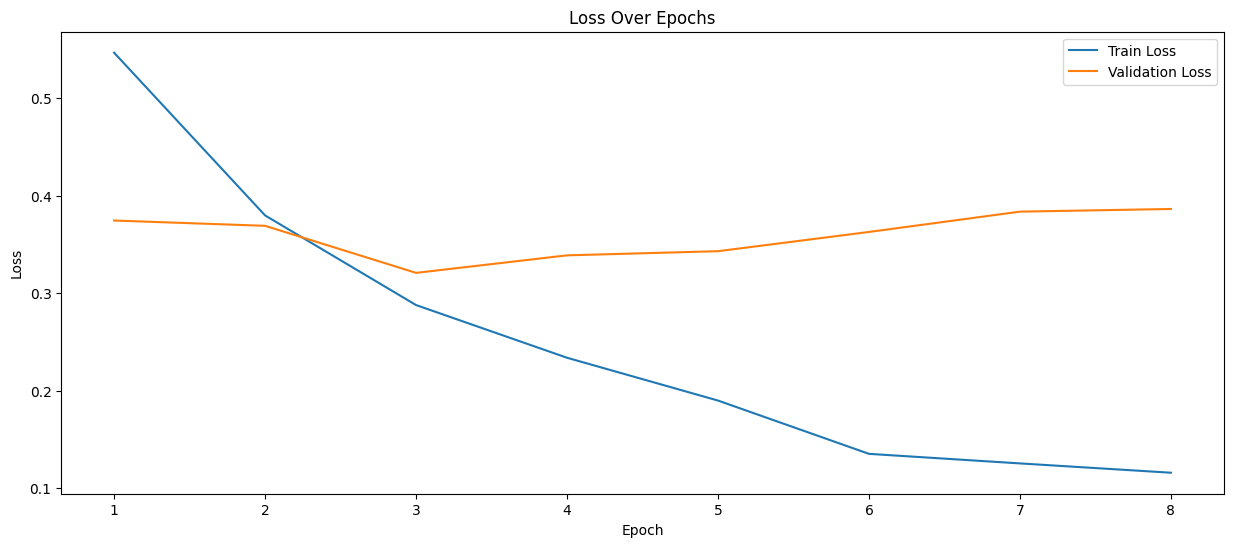

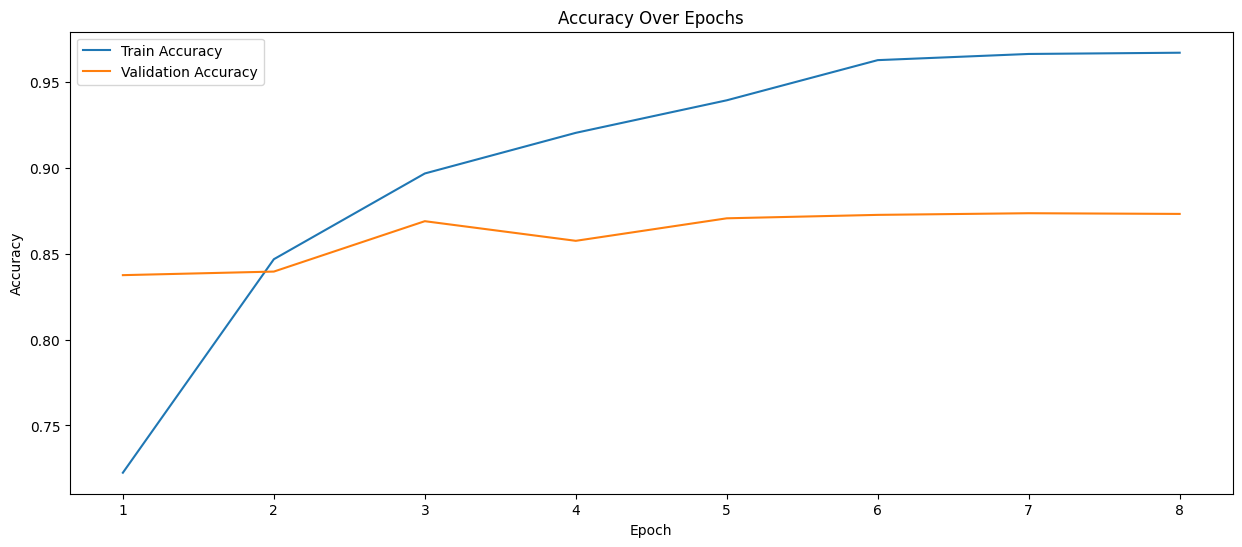

In [ ]:
# Visualize the training history
plot_training_history(lstm_skip_history)

In [ ]:
# Get metrics
lstm_df_skip = get_model_metrics(lstm_skip, X_val_pad, y_val, model_type="dl")
lstm_df_skip

391/391 [==============================] - 4s 10ms/step


,Score
Accuracy,0.869040
Precision,0.840745
Recall,0.910560
F1 Score,0.874261
ROC-AUC,0.942669


### Residual Connections

In [ ]:
# Function for the residual blocks
def residual_block_lstm(x, units):
    # LSTM layer
    lstm_out = layers.LSTM(units, return_sequences=True, dropout=0.2)(x)

    # Normalizing the LSTM output
    norm_out = layers.LayerNormalization()(lstm_out)

    # Convolution to match dimensions if necessary
    if x.shape[-1] != units:
        x = layers.Conv1D(units, 1)(x)

    # Add the shortcut connection
    x = layers.Add()([norm_out, x])

    return x

In [ ]:
# Function to build the LSTM model
def build_residual_lstm_model(input_dim, embedding_dim, maxlen, num_blocks, lstm_units):
    # Input layer
    input_layer = layers.Input(shape=(maxlen,))

    # Embedding layer
    x = layers.Embedding(input_dim, embedding_dim)(input_layer)

    # Residual blocks
    for _ in range(num_blocks):
        x = residual_block_lstm(x, lstm_units)

    # Final LSTM layer
    x = layers.LSTM(lstm_units, return_sequences=False, dropout=0.2)(x)

    # Dense layer
    x = layers.Dense(16, activation="relu")(x)

    # Dropout layer
    x = layers.Dropout(0.5)(x)

    # Output layer
    output_layer = layers.Dense(1, activation="sigmoid")(x)

    # Create the model
    model = keras.Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 250)]                0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 250, 16)              160000    ['input_3[0][0]']             
                                                                                                  
 lstm_3 (LSTM)               (None, 250, 16)              2112      ['embedding_2[0][0]']         
                                                                                                  
 layer_normalization_2 (Lay  (None, 250, 16)              32        ['lstm_3[0][0]']              
 erNormalization)                                                                           

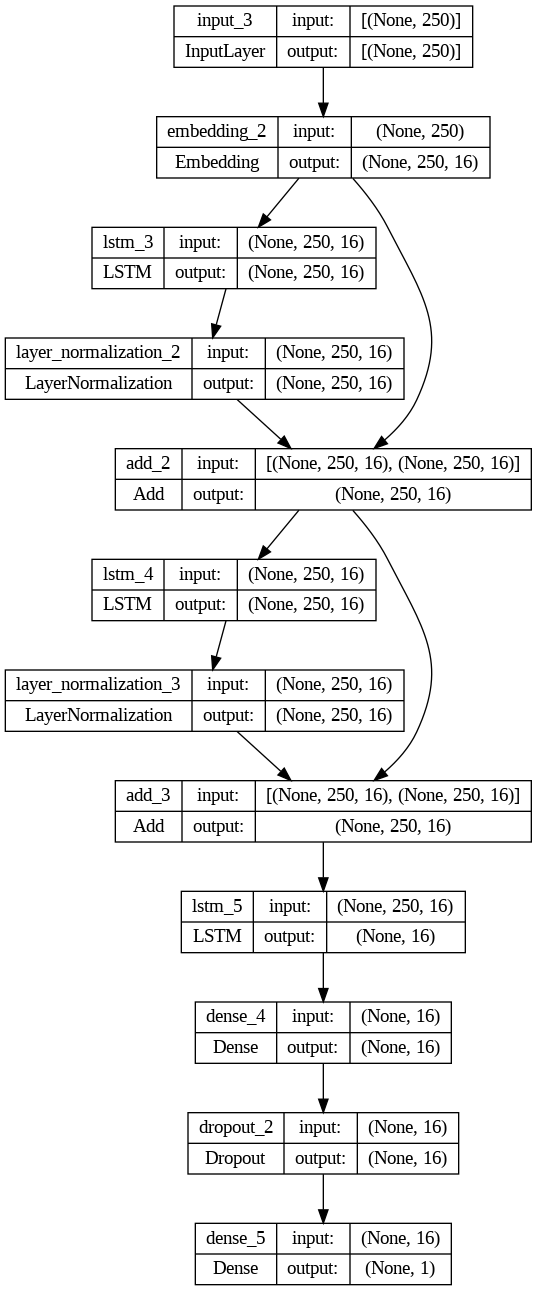

In [ ]:
# Build the model
lstm_residual = build_residual_lstm_model(num_words, embedding_dim, maxlen, num_blocks, 16)

# Get model summary
lstm_residual.summary()

# Plot the model
utils.plot_model(lstm_residual, show_shapes=True)

In [ ]:
# Train the model
lstm_residual_history = lstm_residual.fit(
    X_train_pad, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_pad, y_val),
    callbacks=create_callbacks()
)

Epoch 1/12
391/391 [==============================] - 38s 85ms/step - loss: 0.5830 - accuracy: 0.6787 - val_loss: 0.4026 - val_accuracy: 0.8365 - lr: 0.0010
Epoch 2/12
391/391 [==============================] - 19s 48ms/step - loss: 0.3448 - accuracy: 0.8694 - val_loss: 0.3175 - val_accuracy: 0.8642 - lr: 0.0010
Epoch 3/12
391/391 [==============================] - 14s 35ms/step - loss: 0.2541 - accuracy: 0.9120 - val_loss: 0.3280 - val_accuracy: 0.8710 - lr: 0.0010
Epoch 4/12
391/391 [==============================] - ETA: 0s - loss: 0.2122 - accuracy: 0.9280
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
391/391 [==============================] - 14s 35ms/step - loss: 0.2122 - accuracy: 0.9280 - val_loss: 0.3279 - val_accuracy: 0.8720 - lr: 0.0010
Epoch 5/12
391/391 [==============================] - 14s 35ms/step - loss: 0.1394 - accuracy: 0.9588 - val_loss: 0.4118 - val_accuracy: 0.8721 - lr: 1.0000e-04
Epoch 6/12
391/391 [=============================

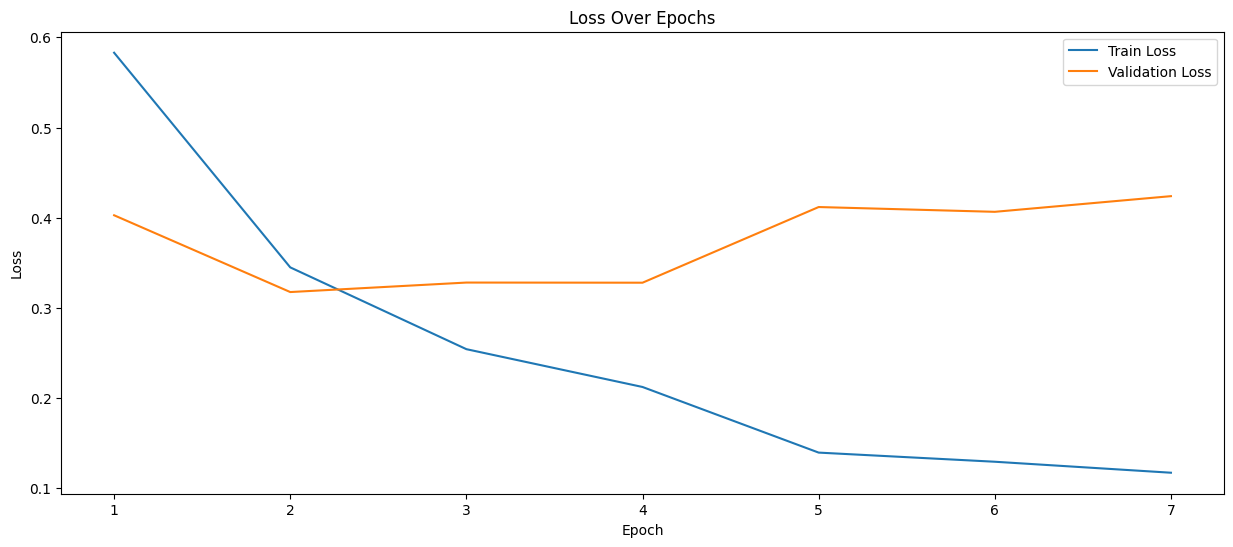

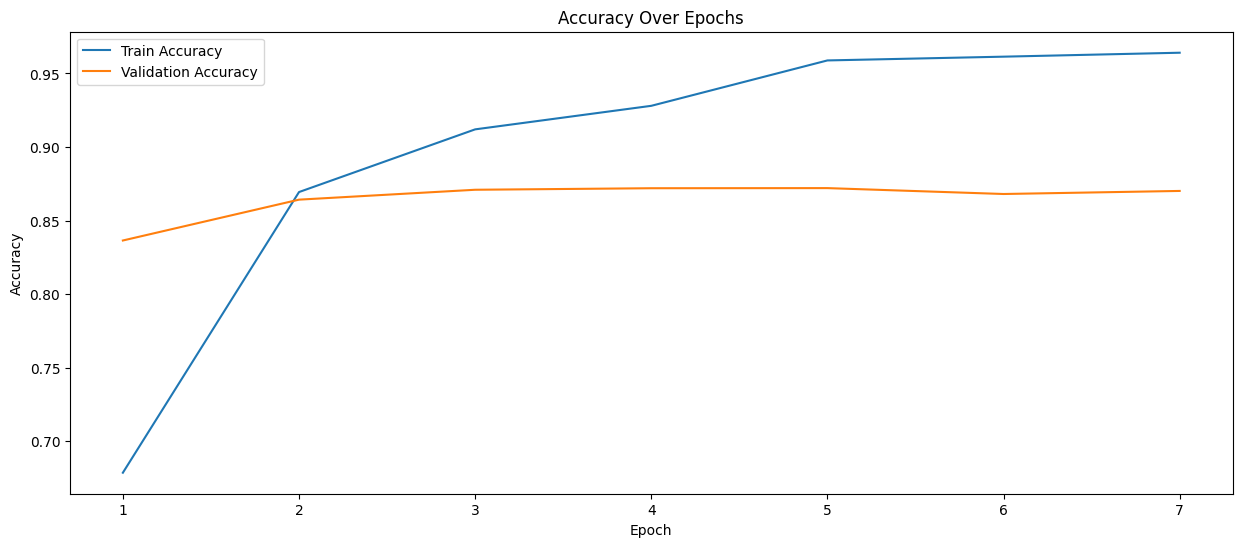

In [ ]:
# Visualize the training history
plot_training_history(lstm_residual_history)

In [ ]:
# Get metrics
lstm_df_residual = get_model_metrics(lstm_residual, X_val_pad, y_val, model_type="dl")
lstm_df_residual

391/391 [==============================] - 4s 10ms/step


,Score
Accuracy,0.864240
Precision,0.851258
Recall,0.882720
F1 Score,0.866703
ROC-AUC,0.940096


### Bidirectionality

In [ ]:
# Function to build the LSTM model
def build_bidirectional_lstm_model(input_dim, embedding_dim, maxlen, lstm_units):
    # Input layer
    input_layer = layers.Input(shape=(maxlen,))

    # Embedding layer
    x = layers.Embedding(input_dim, embedding_dim)(input_layer)

    # Bidirectional LSTM layer
    x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=False, dropout=0.2))(x)

    # Dense layer
    x = layers.Dense(16, activation="relu")(x)

    # Dropout layer
    x = layers.Dropout(0.5)(x)

    # Output layer
    output_layer = layers.Dense(1, activation="sigmoid")(x)

    # Create the model
    model = models.Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 250)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 250, 16)           160000    
                                                                 
 bidirectional (Bidirection  (None, 32)                4224      
 al)                                                             
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                           

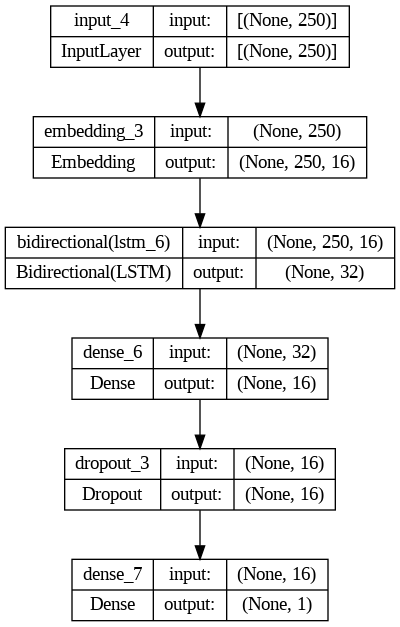

In [ ]:
# Build the model
lstm_bidirectional = build_bidirectional_lstm_model(num_words, embedding_dim, maxlen, 16)

# Get model summary
lstm_bidirectional.summary()

# Plot the model
utils.plot_model(lstm_bidirectional, show_shapes=True)

In [ ]:
# Train the model
lstm_bidirectional_history = lstm_bidirectional.fit(
    X_train_pad, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_pad, y_val),
    callbacks=create_callbacks()
)

Epoch 1/12
391/391 [==============================] - 32s 73ms/step - loss: 0.5395 - accuracy: 0.7116 - val_loss: 0.3281 - val_accuracy: 0.8646 - lr: 0.0010
Epoch 2/12
391/391 [==============================] - 15s 38ms/step - loss: 0.3166 - accuracy: 0.8889 - val_loss: 0.3614 - val_accuracy: 0.8347 - lr: 0.0010
Epoch 3/12
391/391 [==============================] - 10s 26ms/step - loss: 0.2389 - accuracy: 0.9193 - val_loss: 0.3105 - val_accuracy: 0.8683 - lr: 0.0010
Epoch 4/12
391/391 [==============================] - 10s 26ms/step - loss: 0.1951 - accuracy: 0.9353 - val_loss: 0.3604 - val_accuracy: 0.8686 - lr: 0.0010
Epoch 5/12
391/391 [==============================] - ETA: 0s - loss: 0.1610 - accuracy: 0.9481
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
391/391 [==============================] - 10s 26ms/step - loss: 0.1610 - accuracy: 0.9481 - val_loss: 0.3701 - val_accuracy: 0.8619 - lr: 0.0010
Epoch 6/12
391/391 [==============================] -

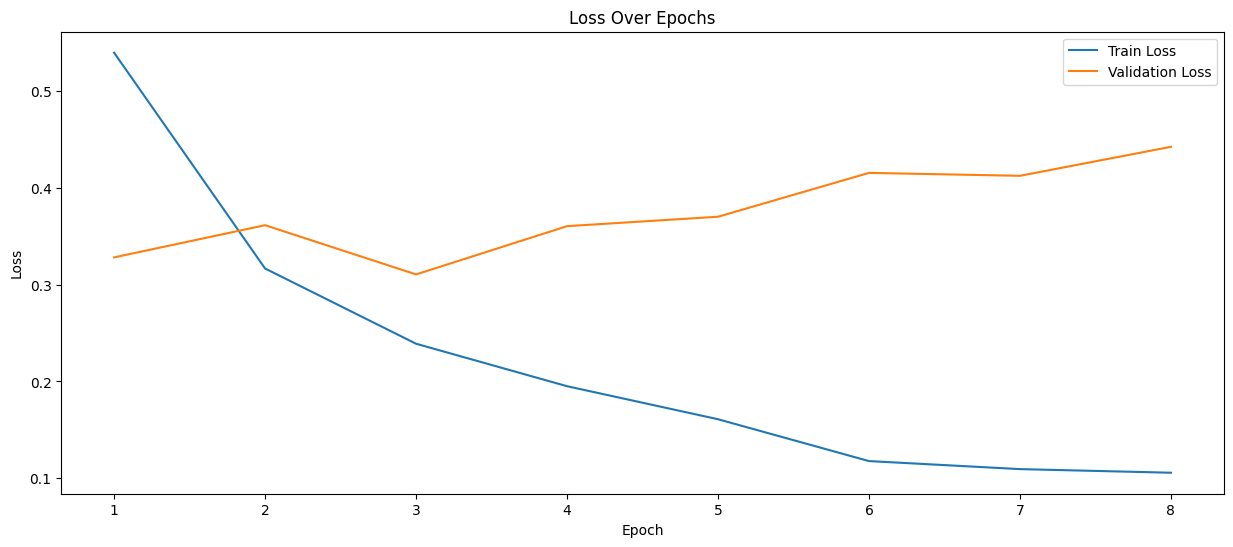

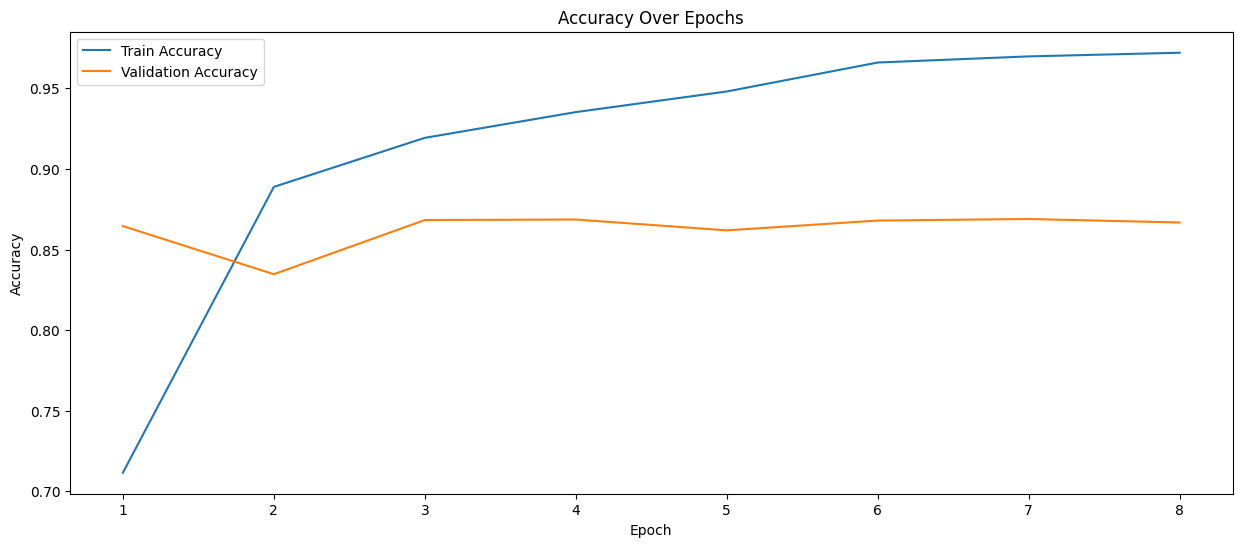

In [ ]:
# Visualize the training history
plot_training_history(lstm_bidirectional_history)

In [ ]:
# Get metrics
lstm_df_bidirectional = get_model_metrics(lstm_bidirectional, X_val_pad, y_val, model_type="dl")
lstm_df_bidirectional

391/391 [==============================] - 2s 6ms/step


,Score
Accuracy,0.868320
Precision,0.870454
Recall,0.865440
F1 Score,0.867940
ROC-AUC,0.941591


### Encoder-Decoder

In [ ]:
# Function to build the LSTM model
def build_encoder_decoder_lstm_model(input_dim, embedding_dim, maxlen, lstm_units):
    # Encoder input layer
    encoder_inputs = layers.Input(shape=(maxlen,))

    # Encoder embedding layer
    encoder_embedding = layers.Embedding(input_dim, embedding_dim)(encoder_inputs)

    # Encoder LSTM layer
    encoder_outputs, state_h, state_c = layers.LSTM(lstm_units, return_state=True)(encoder_embedding)
    encoder_states = [state_h, state_c]

    # Decoder dense layer
    decoder_dense = layers.Dense(16, activation="relu")

    # Decoder dropout layer
    decoder_dropout = layers.Dropout(0.5)

    # Output layer
    output_layer = layers.Dense(1, activation="sigmoid")

    # Use encoder states as input to the dense layer
    decoder_output = decoder_dense(state_h)
    decoder_output = decoder_dropout(decoder_output)
    decoder_output = output_layer(decoder_output)

    # Create the model
    model = models.Model(inputs=encoder_inputs, outputs=decoder_output)

    # Compile the model
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 250)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 250, 16)           160000    
                                                                 
 lstm_7 (LSTM)               [(None, 16),              2112      
                              (None, 16),                        
                              (None, 16)]                        
                                                                 
 dense_8 (Dense)             (None, 16)                272       
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 17  

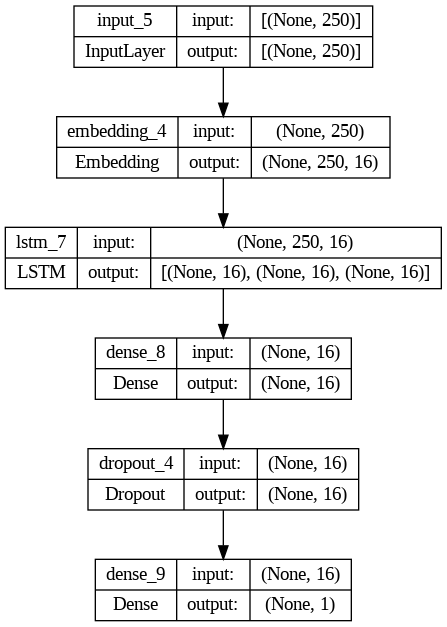

In [ ]:
# Build the model
lstm_encoder_decoder = build_encoder_decoder_lstm_model(num_words, embedding_dim, maxlen, 16)

# Get model summary
lstm_encoder_decoder.summary()

# Plot the model
utils.plot_model(lstm_encoder_decoder, show_shapes=True)

In [ ]:
# Train the model
lstm_encoder_decoder_history = lstm_encoder_decoder.fit(
    X_train_pad, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_pad, y_val),
    callbacks=create_callbacks()
)

Epoch 1/12
391/391 [==============================] - 27s 64ms/step - loss: 0.5001 - accuracy: 0.7518 - val_loss: 0.3429 - val_accuracy: 0.8550 - lr: 0.0010
Epoch 2/12
391/391 [==============================] - 12s 32ms/step - loss: 0.2776 - accuracy: 0.9012 - val_loss: 0.3078 - val_accuracy: 0.8738 - lr: 0.0010
Epoch 3/12
391/391 [==============================] - 7s 19ms/step - loss: 0.2077 - accuracy: 0.9304 - val_loss: 0.3201 - val_accuracy: 0.8655 - lr: 0.0010
Epoch 4/12
391/391 [==============================] - ETA: 0s - loss: 0.1650 - accuracy: 0.9452
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
391/391 [==============================] - 7s 19ms/step - loss: 0.1650 - accuracy: 0.9452 - val_loss: 0.3637 - val_accuracy: 0.8595 - lr: 0.0010
Epoch 5/12
391/391 [==============================] - 7s 19ms/step - loss: 0.1124 - accuracy: 0.9688 - val_loss: 0.4206 - val_accuracy: 0.8667 - lr: 1.0000e-04
Epoch 6/12
391/391 [==============================] 

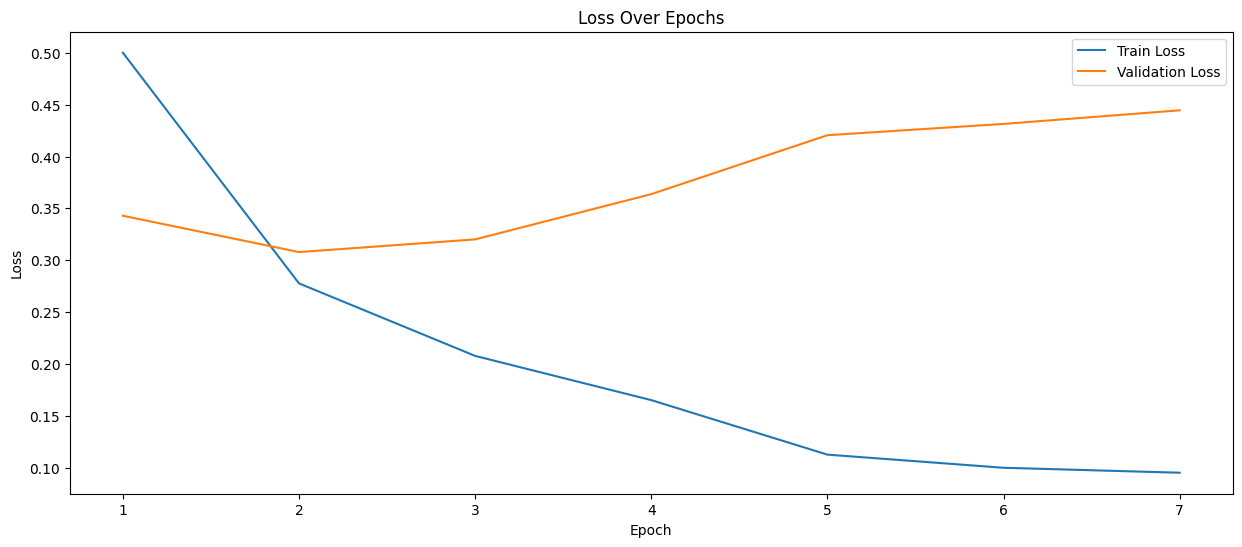

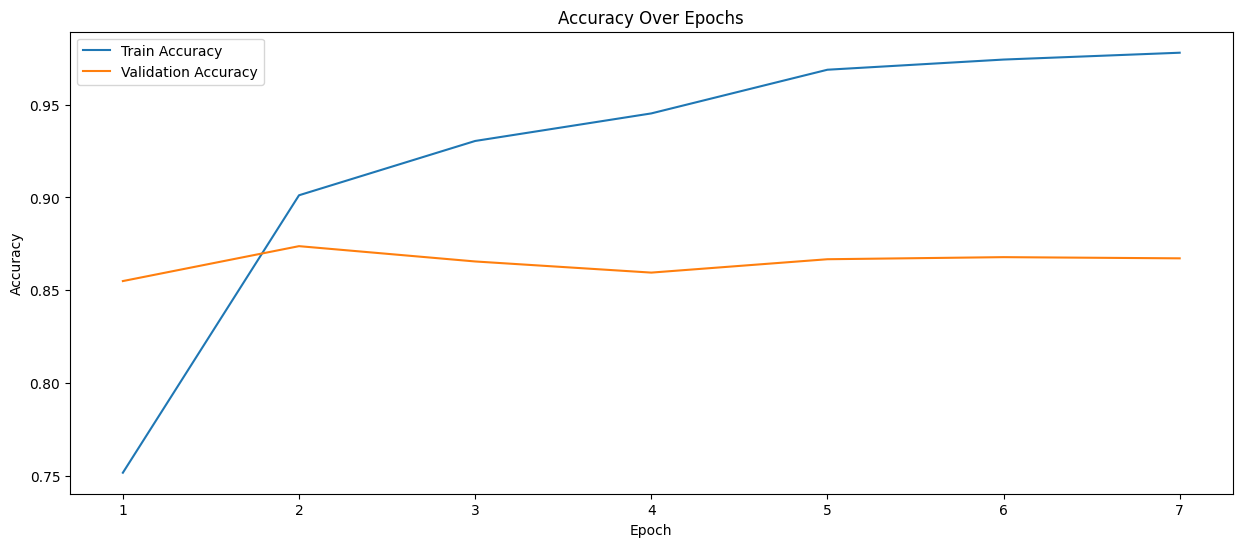

In [ ]:
# Visualize the training history
plot_training_history(lstm_encoder_decoder_history)

In [ ]:
# Get metrics
lstm_df_encoder_decoder = get_model_metrics(lstm_encoder_decoder, X_val_pad, y_val, model_type="dl")
lstm_df_encoder_decoder

391/391 [==============================] - 2s 4ms/step


,Score
Accuracy,0.873760
Precision,0.880456
Recall,0.864960
F1 Score,0.872639
ROC-AUC,0.946880


### Attention Mechanism

In [ ]:
# Function to build the LSTM model
def build_attention_lstm_model(input_dim, embedding_dim, maxlen, lstm_units, num_heads):
    # Input layer
    input_layer = layers.Input(shape=(maxlen,))

    # Embedding layer
    x = layers.Embedding(input_dim, embedding_dim)(input_layer)

    # LSTM layer
    lstm_out = layers.LSTM(lstm_units, return_sequences=True)(x)

    # Multi-head attention layer
    attention_out = layers.MultiHeadAttention(num_heads=num_heads, key_dim=lstm_units)(lstm_out, lstm_out)

    # Concatenate LSTM output and attention output
    x = layers.Concatenate()([lstm_out, attention_out])

    # Final LSTM layer
    x = layers.LSTM(lstm_units, return_sequences=False)(x)

    # Dense layer
    x = layers.Dense(16, activation="relu")(x)

    # Dropout layer
    x = layers.Dropout(0.5)(x)

    # Output layer
    output_layer = layers.Dense(1, activation="sigmoid")(x)

    # Create the model
    model = models.Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 250)]                0         []                            
                                                                                                  
 embedding_5 (Embedding)     (None, 250, 16)              160000    ['input_6[0][0]']             
                                                                                                  
 lstm_8 (LSTM)               (None, 250, 16)              2112      ['embedding_5[0][0]']         
                                                                                                  
 multi_head_attention (Mult  (None, 250, 16)              2160      ['lstm_8[0][0]',              
 iHeadAttention)                                                     'lstm_8[0][0]']        

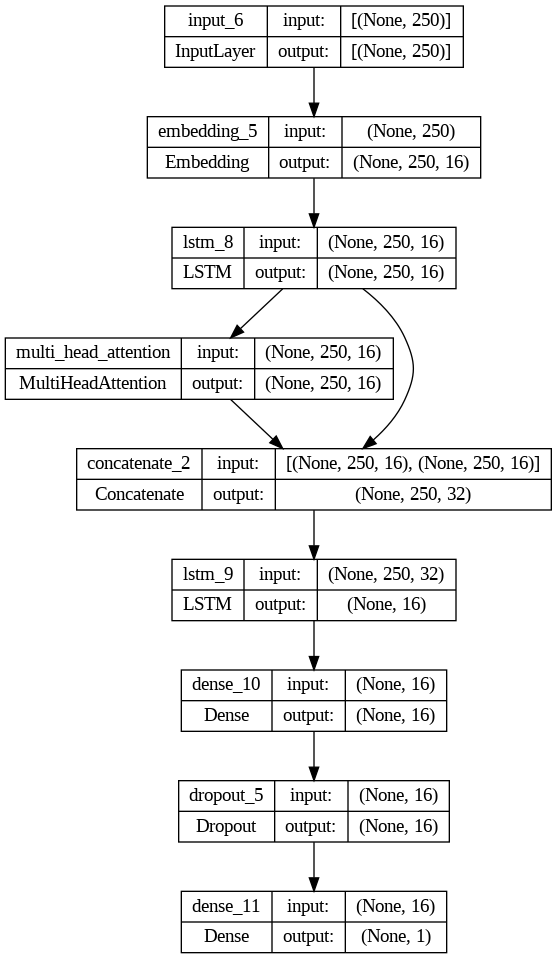

In [ ]:
# Build the model
lstm_attention = build_attention_lstm_model(num_words, embedding_dim, maxlen, 16, 2)

# Get model summary
lstm_attention.summary()

# Plot the model
utils.plot_model(lstm_attention, show_shapes=True)

In [ ]:
# Train the model
lstm_attention_history = lstm_attention.fit(
    X_train_pad, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_pad, y_val),
    callbacks=create_callbacks()
)

Epoch 1/12
391/391 [==============================] - 34s 75ms/step - loss: 0.4870 - accuracy: 0.7625 - val_loss: 0.3231 - val_accuracy: 0.8681 - lr: 0.0010
Epoch 2/12
391/391 [==============================] - 16s 41ms/step - loss: 0.2708 - accuracy: 0.9028 - val_loss: 0.3036 - val_accuracy: 0.8709 - lr: 0.0010
Epoch 3/12
391/391 [==============================] - 12s 30ms/step - loss: 0.1996 - accuracy: 0.9329 - val_loss: 0.3263 - val_accuracy: 0.8634 - lr: 0.0010
Epoch 4/12
391/391 [==============================] - ETA: 0s - loss: 0.1591 - accuracy: 0.9492
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
391/391 [==============================] - 11s 29ms/step - loss: 0.1591 - accuracy: 0.9492 - val_loss: 0.3939 - val_accuracy: 0.8682 - lr: 0.0010
Epoch 5/12
391/391 [==============================] - 11s 29ms/step - loss: 0.0971 - accuracy: 0.9738 - val_loss: 0.4458 - val_accuracy: 0.8654 - lr: 1.0000e-04
Epoch 6/12
391/391 [=============================

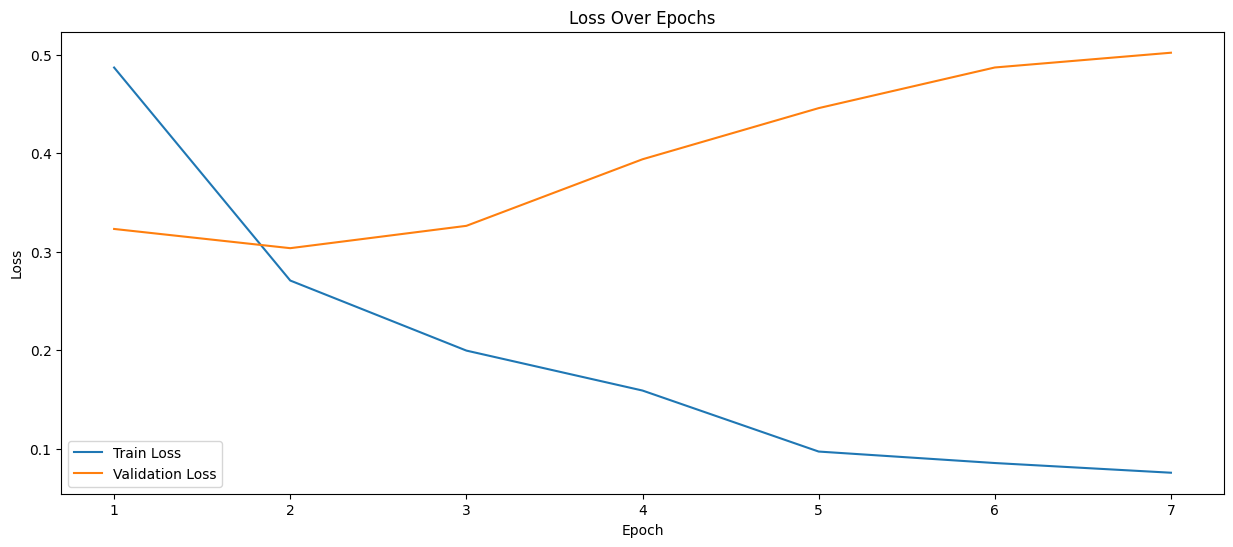

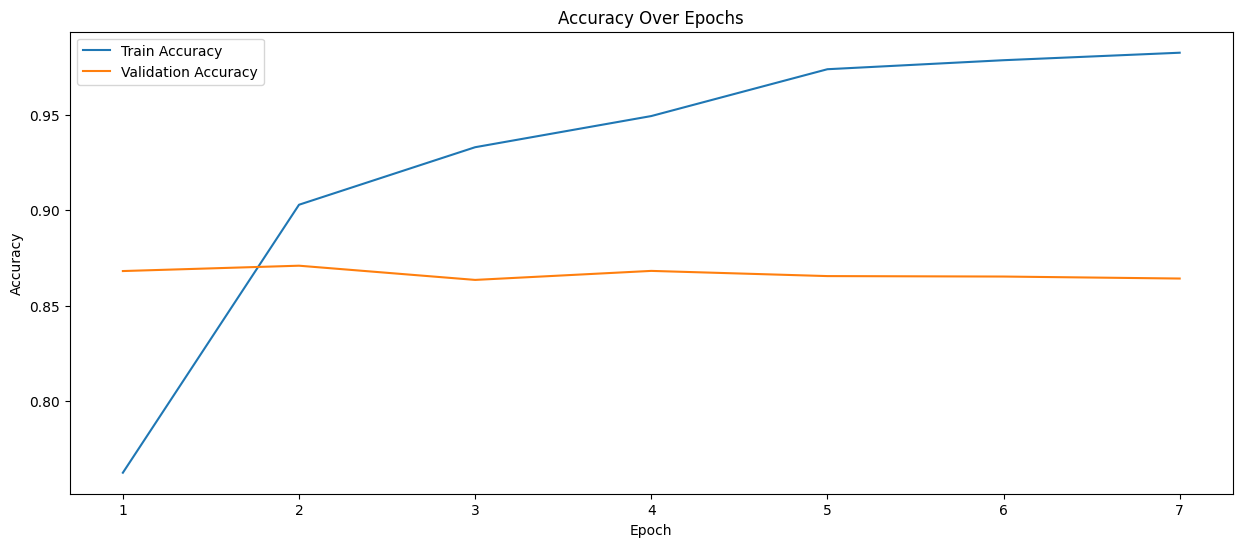

In [ ]:
# Visualize the training history
plot_training_history(lstm_attention_history)

In [ ]:
# Get metrics
lstm_df_attention = get_model_metrics(lstm_attention, X_val_pad, y_val, model_type="dl")
lstm_df_attention

391/391 [==============================] - 3s 7ms/step


,Score
Accuracy,0.870880
Precision,0.886333
Recall,0.850880
F1 Score,0.868245
ROC-AUC,0.947143


### LSTM Model Comparison

In [ ]:
# Create dictionary of metrics DataFrames
lstm_metrics_dict = {
    "Skip Connections": lstm_df_skip,
    "Residual Connections": lstm_df_residual,
    "Bidirectional LSTM": lstm_df_bidirectional,
    "Encoder-Decoder": lstm_df_encoder_decoder,
    "Multi-Head Attention": lstm_df_attention
}

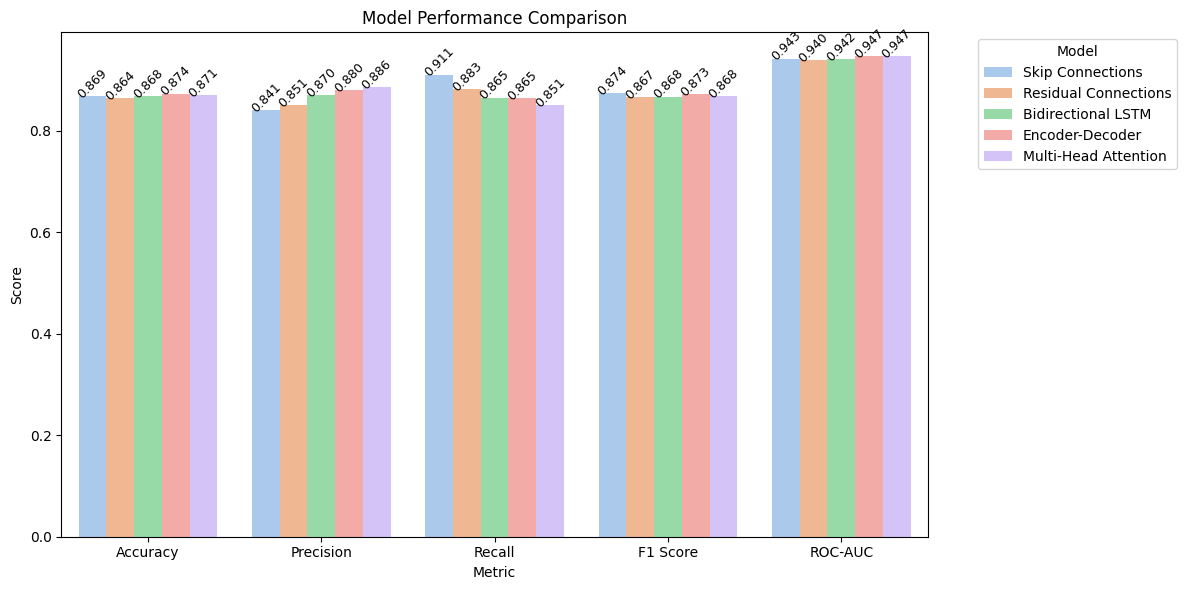

In [ ]:
# Create plots
compare_model_performance(lstm_metrics_dict)

# Hyperparameter Tuning

## Random Forest

In [ ]:
# Objective function
def objective_rf(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 300)
    max_depth = trial.suggest_int("max_depth", 10, 100)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 15)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 14)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2"])
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])

    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        criterion=criterion,
        random_state=42
    )

    rf.fit(X_train_bow, y_train)
    accuracy = rf.score(X_val_bow, y_val)

    return accuracy

In [ ]:
# Run the study
pruner = optuna.pruners.MedianPruner(n_startup_trials=5)
study_rf = optuna.create_study(direction="maximize", pruner=pruner)
study_rf.optimize(objective_rf, n_trials=10)

[I 2024-02-01 17:58:26,809] A new study created in memory with name: no-name-743dd620-0bef-461d-a077-82b9dc6b63c5
[I 2024-02-01 17:58:28,657] Trial 0 finished with value: 0.78072 and parameters: {'n_estimators': 13, 'max_depth': 51, 'min_samples_split': 3, 'min_samples_leaf': 12, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 0 with value: 0.78072.
[I 2024-02-01 17:59:06,046] Trial 1 finished with value: 0.84528 and parameters: {'n_estimators': 89, 'max_depth': 81, 'min_samples_split': 3, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 1 with value: 0.84528.
[I 2024-02-01 17:59:23,327] Trial 2 finished with value: 0.8516 and parameters: {'n_estimators': 168, 'max_depth': 39, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 2 with value: 0.8516.
[I 2024-02-01 17:59:49,048] Trial 3 finished with value: 0.84264 and parameters: {'n_estimators': 48, 'max_depth': 98, 'min_samples_split':

In [ ]:
# Best parameters
best_params_rf = study_rf.best_params
print(f"Best parameters for Random Forest: {best_params_rf}")

Best parameters for Random Forest: {'n_estimators': 259, 'max_depth': 92, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'criterion': 'entropy'}


In [ ]:
# Rebuild the model
rf_best = RandomForestClassifier(
    n_estimators=best_params_rf["n_estimators"],
    max_depth=best_params_rf["max_depth"],
    min_samples_split=best_params_rf["min_samples_split"],
    min_samples_leaf=best_params_rf["min_samples_leaf"],
    max_features=best_params_rf["max_features"],
    criterion=best_params_rf["criterion"],
    random_state=42
)

In [ ]:
# Train the rebuilt model
rf_best.fit(X_train_bow, y_train)

RandomForestClassifier(criterion='entropy', max_depth=92, min_samples_leaf=3,
                       min_samples_split=12, n_estimators=259, random_state=42)

In [ ]:
# Get metrics
rf_df_best = get_model_metrics(rf_best, X_val_bow, y_val, model_type="ml")
rf_df_best

,Score
Accuracy,0.858720
Precision,0.848570
Recall,0.873280
F1 Score,0.860748
ROC-AUC,0.858720


## Support Vector Machine

In [ ]:
# Objective function
def objective_svm(trial):
    C = trial.suggest_float("C", 1e-4, 1e2, log=True)
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf"])
    gamma = trial.suggest_categorical("gamma", ["scale", "auto"])

    svm = SVC(C=C, kernel=kernel, gamma=gamma, random_state=42)
    svm.fit(X_train_tfidf_svd, y_train)
    accuracy = svm.score(X_val_tfidf_svd, y_val)

    return accuracy

In [ ]:
# Run the study
pruner = optuna.pruners.MedianPruner(n_startup_trials=5)
study_svm = optuna.create_study(direction="maximize", pruner=pruner)
study_svm.optimize(objective_svm, n_trials=10)

[I 2024-02-01 18:10:10,910] A new study created in memory with name: no-name-89ba0749-d9d2-4690-80f3-1205bd8a61b2
[I 2024-02-01 18:10:42,412] Trial 0 finished with value: 0.84264 and parameters: {'C': 26.788347236510596, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 0 with value: 0.84264.
[I 2024-02-01 18:11:15,517] Trial 1 finished with value: 0.83664 and parameters: {'C': 0.10541686177207675, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 0 with value: 0.84264.
[I 2024-02-01 18:12:00,241] Trial 2 finished with value: 0.84208 and parameters: {'C': 14.78088522241803, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 0 with value: 0.84264.
[I 2024-02-01 18:12:49,282] Trial 3 finished with value: 0.69192 and parameters: {'C': 0.00030510176854896715, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 0 with value: 0.84264.
[I 2024-02-01 18:13:36,907] Trial 4 finished with value: 0.8408 and parameters: {'C': 9.721063090045677, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 0

In [ ]:
# Best parameters
best_params_svm = study_svm.best_params
print(f"Best parameters for SVM: {best_params_svm}")

Best parameters for SVM: {'C': 14.21896531303459, 'kernel': 'linear', 'gamma': 'scale'}


In [ ]:
# Rebuild the model
svm_best = SVC(
    C=best_params_svm["C"],
    kernel=best_params_svm["kernel"],
    gamma=best_params_svm["gamma"],
    probability=True,
    random_state=42
)

In [ ]:
# Train the rebuilt model
svm_best.fit(X_train_tfidf_svd, y_train)

SVC(C=14.21896531303459, kernel='linear', probability=True, random_state=42)

In [ ]:
# Get metrics
svm_df_best = get_model_metrics(svm_best, X_val_tfidf_svd, y_val, model_type="ml")
svm_df_best

,Score
Accuracy,0.843040
Precision,0.839026
Recall,0.848960
F1 Score,0.843964
ROC-AUC,0.843040


## Convolutional Neural Network

### Tuning

In [ ]:
# Function for tuning residual blocks
def tunable_residual_block_cnn(trial, x, layer_index, l2_reg):
    filters = trial.suggest_int(f"res_conv_{layer_index}_filters", 16, 128)
    kernel_size = trial.suggest_int(f"res_conv_{layer_index}_kernel_size", 3, 5)

    # Create regularizer
    l2_reg = keras.regularizers.l2(l2_reg)

    # Start of residual block
    shortcut = x

    # First convolutional block
    x = layers.Conv1D(filters, kernel_size, padding="same", kernel_regularizer=l2_reg, kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Second convolutional block
    x = layers.Conv1D(filters, kernel_size, padding="same", kernel_regularizer=l2_reg, kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)

    # Convolutional shortcut to match dimensions
    if x.shape[-1] != shortcut.shape[-1]:
        shortcut = layers.Conv1D(filters, kernel_size, padding="same", kernel_regularizer=l2_reg, kernel_initializer="he_normal")(shortcut)

    # Add the shortcut
    x = layers.Add()([x, shortcut])
    x = layers.Activation("relu")(x)

    return x

In [ ]:
# Function to build tunable CNN model
def build_tunable_cnn_model(trial, input_dim, maxlen):
    embedding_dim = trial.suggest_int("embedding_dim", 16, 128)
    num_blocks = trial.suggest_int("num_residual_blocks", 0, 5)
    num_filters = trial.suggest_int("num_filters", 16, 128)
    kernel_size = trial.suggest_int("kernel_size", 3, 5)
    dense_units = trial.suggest_int("dense_units", 16, 128)
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.7)
    l2_reg = trial.suggest_float("l2_reg", 1e-4, 1e-2, log=True)

    # Input layer
    input_layer = layers.Input(shape=(maxlen,))

    # Embedding layer
    x = layers.Embedding(input_dim, embedding_dim)(input_layer)

    # Residual blocks
    for i in range(num_blocks):
        x = tunable_residual_block_cnn(trial, x, layer_index=i, l2_reg=l2_reg)

    # Reduce dimensions
    x = layers.GlobalMaxPooling1D()(x)

    # Dense layer
    x = layers.Dense(dense_units, activation="relu")(x)

    # Dropout layer
    x = layers.Dropout(dropout_rate)(x)

    # Output layer
    output_layer = layers.Dense(1, activation="sigmoid")(x)

    # Create the model
    model = keras.Model(inputs=input_layer, outputs=output_layer)

    # Set optimizer options
    optimizer_options = {
        "adam": keras.optimizers.Adam(learning_rate=trial.suggest_float("adam_lr", 1e-4, 1e-2, log=True)),
        "adafactor": keras.optimizers.Adafactor(learning_rate=trial.suggest_float("adafactor_lr", 1e-4, 1e-2, log=True)),
    }
    optimizer_name = trial.suggest_categorical("optimizer", ["adam", "adafactor"])
    optimizer = optimizer_options[optimizer_name]

    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [ ]:
# Objective function
def objective_cnn(trial):
    # Build the model
    model = build_tunable_cnn_model(trial, num_words, maxlen)

    # Train with callbacks
    history = model.fit(
        X_train_pad, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val_pad, y_val),
        callbacks=create_callbacks(verbose=0),
        verbose=0
    )

    # Evaluate on validation data
    val_loss, val_accuracy = model.evaluate(X_val_pad, y_val, verbose=0)

    return val_accuracy

In [ ]:
# Run the study
pruner = optuna.pruners.MedianPruner(n_startup_trials=5)
study_cnn = optuna.create_study(direction="maximize", pruner=pruner)
study_cnn.optimize(objective_cnn, n_trials=10)

[I 2024-02-01 18:19:38,562] A new study created in memory with name: no-name-29d1329e-2634-4569-958c-7005d8f6bb20
[I 2024-02-01 18:23:46,130] Trial 0 finished with value: 0.7700799703598022 and parameters: {'embedding_dim': 71, 'num_residual_blocks': 5, 'num_filters': 37, 'kernel_size': 5, 'dense_units': 87, 'dropout_rate': 0.4895537040763136, 'l2_reg': 0.001229413102501817, 'res_conv_0_filters': 48, 'res_conv_0_kernel_size': 5, 'res_conv_1_filters': 126, 'res_conv_1_kernel_size': 3, 'res_conv_2_filters': 84, 'res_conv_2_kernel_size': 3, 'res_conv_3_filters': 37, 'res_conv_3_kernel_size': 3, 'res_conv_4_filters': 83, 'res_conv_4_kernel_size': 4, 'adam_lr': 0.0002308798929281195, 'adafactor_lr': 0.0008399339634743274, 'optimizer': 'adam'}. Best is trial 0 with value: 0.7700799703598022.
[I 2024-02-01 18:25:13,034] Trial 1 finished with value: 0.8487200140953064 and parameters: {'embedding_dim': 20, 'num_residual_blocks': 0, 'num_filters': 114, 'kernel_size': 3, 'dense_units': 47, 'dropo

In [ ]:
# Best parameters
best_params_cnn = study_cnn.best_params
print(f"Best parameters for CNN: {best_params_cnn}")

Best parameters for CNN: {'embedding_dim': 103, 'num_residual_blocks': 0, 'num_filters': 96, 'kernel_size': 5, 'dense_units': 79, 'dropout_rate': 0.5810103594734723, 'l2_reg': 0.0001281455749146177, 'adam_lr': 0.0010834946240499549, 'adafactor_lr': 0.0013369929446550594, 'optimizer': 'adam'}


### Rebuilding

In [ ]:
# Function for the residual blocks
def residual_block_cnn(x, filters, kernel_size, l2_reg):
    # Create regularizer
    l2_reg = keras.regularizers.l2(l2_reg)

    # Start of residual block
    shortcut = x

    # First convolutional block
    x = layers.Conv1D(filters, kernel_size, padding="same", kernel_regularizer=l2_reg, kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Second convolutional block
    x = layers.Conv1D(filters, kernel_size, padding="same", kernel_regularizer=l2_reg, kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)

    # Convolutional shortcut to match dimensions
    if x.shape[-1] != shortcut.shape[-1]:
        shortcut = layers.Conv1D(filters, 1, padding="same", kernel_regularizer=l2_reg, kernel_initializer="he_normal")(shortcut)

    # Add the shortcut
    x = layers.Add()([x, shortcut])
    x = layers.Activation("relu")(x)

    return x

In [ ]:
# Function to rebuild the model
def build_best_cnn(best_params, input_dim, maxlen):
    # Unpack the best parameters
    embedding_dim = best_params["embedding_dim"]
    num_blocks = best_params["num_residual_blocks"]
    num_filters = best_params["num_filters"]
    kernel_size = best_params["kernel_size"]
    dense_units = best_params["dense_units"]
    dropout_rate = best_params["dropout_rate"]
    l2_reg = best_params["l2_reg"]
    optimizer_name = best_params["optimizer"]

    # Input layer
    input_layer = layers.Input(shape=(maxlen,))

    # Embedding layer
    x = layers.Embedding(input_dim, embedding_dim)(input_layer)

    # Residual blocks
    for _ in range(num_blocks):
        x = residual_block_cnn(x, num_filters, kernel_size, l2_reg=l2_reg)

    # Reduce dimensions
    x = layers.GlobalMaxPooling1D()(x)

    # Dense layer
    x = layers.Dense(dense_units, activation="relu")(x)

    # Dropout layer
    x = layers.Dropout(dropout_rate)(x)

    # Output layer
    output_layer = layers.Dense(1, activation="sigmoid")(x)

    # Create the model
    model = keras.Model(inputs=input_layer, outputs=output_layer)

    # Optimizer selection
    if optimizer_name == "adam":
        optimizer = keras.optimizers.Adam(learning_rate=best_params["adam_lr"])
    elif optimizer_name == "adafactor":
        optimizer = keras.optimizers.Adafactor(learning_rate=best_params["adafactor_lr"])

    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [ ]:
# Rebuild the model
cnn_best = build_best_cnn(
    best_params=best_params_cnn,
    input_dim=num_words,
    maxlen=maxlen
)

In [ ]:
# Train the rebuilt model
cnn_best_history = cnn_best.fit(
    X_train_pad, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_pad, y_val),
    callbacks=create_callbacks(),
    verbose=1
)

Epoch 1/12
391/391 [==============================] - 25s 62ms/step - loss: 0.5137 - accuracy: 0.7454 - val_loss: 0.3247 - val_accuracy: 0.8642 - lr: 0.0011
Epoch 2/12
391/391 [==============================] - 11s 27ms/step - loss: 0.2732 - accuracy: 0.8907 - val_loss: 0.2935 - val_accuracy: 0.8757 - lr: 0.0011
Epoch 3/12
391/391 [==============================] - 5s 14ms/step - loss: 0.1855 - accuracy: 0.9334 - val_loss: 0.3059 - val_accuracy: 0.8736 - lr: 0.0011
Epoch 4/12
391/391 [==============================] - ETA: 0s - loss: 0.1189 - accuracy: 0.9628
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010834946297109128.
391/391 [==============================] - 5s 13ms/step - loss: 0.1189 - accuracy: 0.9628 - val_loss: 0.3432 - val_accuracy: 0.8682 - lr: 0.0011
Epoch 5/12
391/391 [==============================] - 5s 14ms/step - loss: 0.0601 - accuracy: 0.9873 - val_loss: 0.3563 - val_accuracy: 0.8694 - lr: 1.0835e-04
Epoch 6/12
391/391 [==============================] 

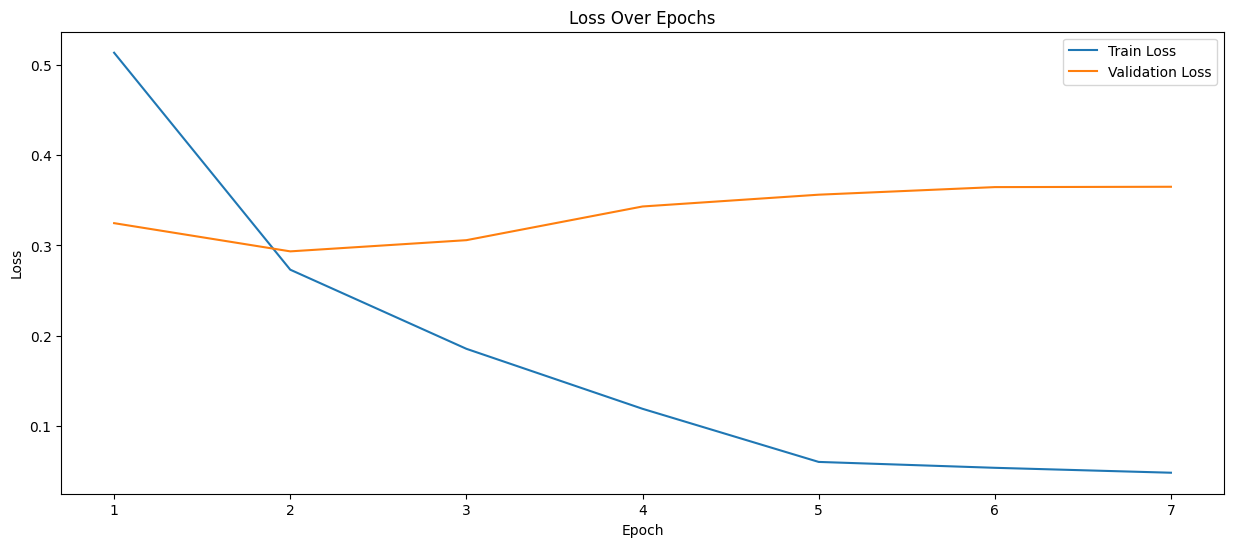

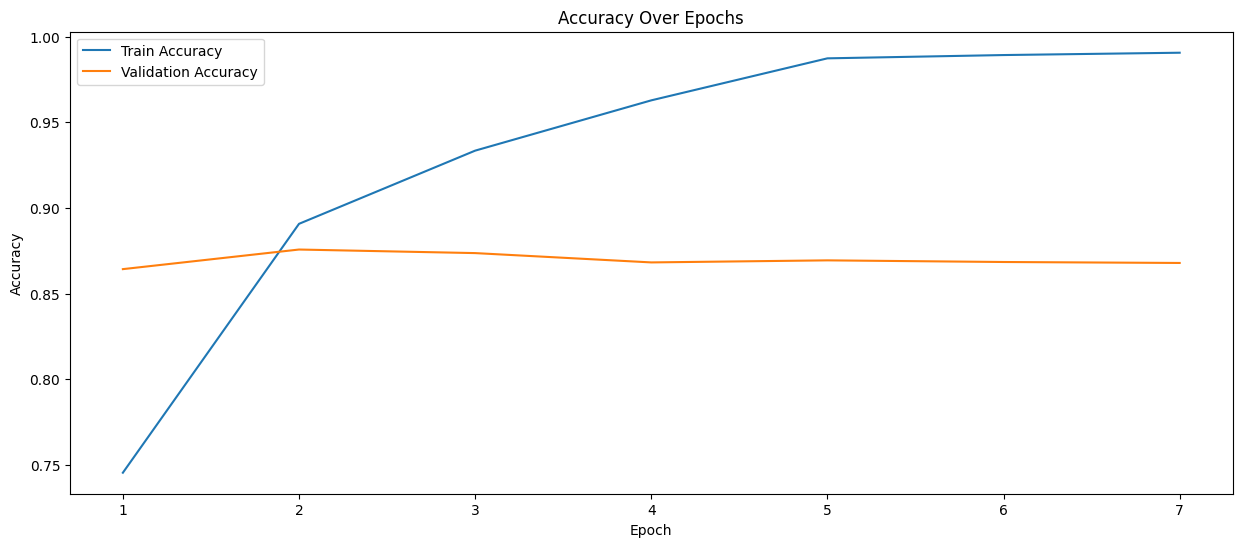

In [ ]:
# Visualize the training history
plot_training_history(cnn_best_history)

In [ ]:
# Get metrics
cnn_df_best = get_model_metrics(cnn_best, X_val_pad, y_val, model_type="dl")
cnn_df_best

391/391 [==============================] - 1s 1ms/step


,Score
Accuracy,0.875680
Precision,0.857491
Recall,0.901120
F1 Score,0.878764
ROC-AUC,0.948456


## LSTM Neural Network

### Tuning

In [ ]:
# Function to build tunable LSTM model
def build_tunable_attention_lstm_model(trial, input_dim, maxlen):
    embedding_dim = trial.suggest_int("embedding_dim", 16, 128)
    lstm_units = trial.suggest_int("lstm_units", 16, 128)
    num_heads = trial.suggest_int("num_heads", 1, 8)
    dense_units = trial.suggest_int("dense_units", 16, 128)
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.7)
    l2_reg = trial.suggest_float("l2_reg", 1e-4, 1e-2, log=True)

    # Create regularizer
    l2_reg = keras.regularizers.l2(l2_reg)

    # Input layer
    input_layer = layers.Input(shape=(maxlen,))

    # Embedding layer
    x = layers.Embedding(input_dim, embedding_dim)(input_layer)

    # LSTM layer
    lstm_out = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True, kernel_regularizer=l2_reg, kernel_initializer="orthogonal"))(x)

    # Multi-head attention layer
    attention_out = layers.MultiHeadAttention(num_heads=num_heads, key_dim=lstm_units)(lstm_out, lstm_out)

    # Concatenate LSTM output and attention output
    x = layers.Concatenate()([lstm_out, attention_out])

    # Final LSTM layer
    x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=False, kernel_regularizer=l2_reg, kernel_initializer="orthogonal"))(x)

    # Dense layer
    x = layers.Dense(dense_units, activation="relu")(x)

    # Dropout layer
    x = layers.Dropout(dropout_rate)(x)

    # Output layer
    output_layer = layers.Dense(1, activation="sigmoid")(x)

    # Create the model
    model = models.Model(inputs=input_layer, outputs=output_layer)

    # Set optimizer options
    optimizer_options = {
        "adam": keras.optimizers.Adam(learning_rate=trial.suggest_float("adam_lr", 1e-4, 1e-2, log=True)),
        "adafactor": keras.optimizers.Adafactor(learning_rate=trial.suggest_float("adafactor_lr", 1e-4, 1e-2, log=True)),
    }
    optimizer_name = trial.suggest_categorical("optimizer", ["adam", "adafactor"])
    optimizer = optimizer_options[optimizer_name]

    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [ ]:
# Objective function
def objective_lstm(trial):
    # Build the model
    model = build_tunable_attention_lstm_model(trial, num_words, maxlen)

    # Train with callbacks
    model.fit(
        X_train_pad, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val_pad, y_val),
        callbacks=create_callbacks(verbose=0),
        verbose=0
    )

    # Evaluate on validation data
    val_loss, val_accuracy = model.evaluate(X_val_pad, y_val, verbose=0)

    return val_accuracy

In [ ]:
# Run the study
pruner = optuna.pruners.MedianPruner(n_startup_trials=5)
study_lstm = optuna.create_study(direction="maximize", pruner=pruner)
study_lstm.optimize(objective_lstm, n_trials=10)

[I 2024-02-01 18:50:59,086] A new study created in memory with name: no-name-59c86fed-1e33-4982-aeb4-e2d327a74fe5
[I 2024-02-01 18:56:57,169] Trial 0 finished with value: 0.8804000020027161 and parameters: {'embedding_dim': 65, 'lstm_units': 67, 'num_heads': 7, 'dense_units': 106, 'dropout_rate': 0.06668799634953143, 'l2_reg': 0.001567766060228307, 'adam_lr': 0.0025510580967521017, 'adafactor_lr': 0.00019202791840795672, 'optimizer': 'adam'}. Best is trial 0 with value: 0.8804000020027161.
[I 2024-02-01 19:01:38,196] Trial 1 finished with value: 0.5 and parameters: {'embedding_dim': 109, 'lstm_units': 37, 'num_heads': 2, 'dense_units': 35, 'dropout_rate': 0.5816641351467986, 'l2_reg': 0.0015940959857113257, 'adam_lr': 0.007296532835740541, 'adafactor_lr': 0.0004197304690957541, 'optimizer': 'adam'}. Best is trial 0 with value: 0.8804000020027161.
[I 2024-02-01 19:10:23,113] Trial 2 finished with value: 0.5 and parameters: {'embedding_dim': 89, 'lstm_units': 97, 'num_heads': 6, 'dense_u

In [ ]:
# Best parameters
best_params_lstm = study_lstm.best_params
print(f"Best parameters for LSTM: {best_params_lstm}")

Best parameters for LSTM: {'embedding_dim': 66, 'lstm_units': 33, 'num_heads': 1, 'dense_units': 45, 'dropout_rate': 0.36044691388449634, 'l2_reg': 0.0002178726895139592, 'adam_lr': 0.00013608352328416828, 'adafactor_lr': 0.00083383741998199, 'optimizer': 'adam'}


### Rebuilding

In [ ]:
# Function to rebuild the model
def build_best_lstm(best_params, input_dim, maxlen):
    # Unpack the best parameters
    embedding_dim = best_params["embedding_dim"]
    lstm_units = best_params["lstm_units"]
    num_heads = best_params["num_heads"]
    dense_units = best_params["dense_units"]
    dropout_rate = best_params["dropout_rate"]
    l2_reg = best_params["l2_reg"]
    optimizer_name = best_params["optimizer"]

    # Create regularizer
    l2_reg = keras.regularizers.l2(l2_reg)

    # Input layer
    input_layer = layers.Input(shape=(maxlen,))

    # Embedding layer
    x = layers.Embedding(input_dim, embedding_dim)(input_layer)

    # LSTM layer
    lstm_out = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True, kernel_regularizer=l2_reg, kernel_initializer="orthogonal"))(x)

    # Multi-head attention layer
    attention_out = layers.MultiHeadAttention(num_heads=num_heads, key_dim=lstm_units)(lstm_out, lstm_out)

    # Concatenate LSTM output and attention output
    x = layers.Concatenate()([lstm_out, attention_out])

    # Final LSTM layer
    x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=False, kernel_regularizer=l2_reg, kernel_initializer="orthogonal"))(x)

    # Dense layer
    x = layers.Dense(dense_units, activation="relu")(x)

    # Dropout layer
    x = layers.Dropout(dropout_rate)(x)

    # Output layer
    output_layer = layers.Dense(1, activation="sigmoid")(x)

    # Create the model
    model = models.Model(inputs=input_layer, outputs=output_layer)

    # Optimizer selection
    if optimizer_name == "adam":
        optimizer = keras.optimizers.Adam(learning_rate=best_params["adam_lr"])
    elif optimizer_name == "adafactor":
        optimizer = keras.optimizers.Adafactor(learning_rate=best_params["adafactor_lr"])

    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [ ]:
# Rebuild the model
lstm_best = build_best_lstm(
    best_params=best_params_lstm,
    input_dim=num_words,
    maxlen=maxlen
)

In [ ]:
# Train the rebuilt model
lstm_best_history = lstm_best.fit(
    X_train_pad, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_pad, y_val),
    callbacks=create_callbacks(),
    verbose=1
)

Epoch 1/12
391/391 [==============================] - 46s 101ms/step - loss: 0.5998 - accuracy: 0.7087 - val_loss: 0.3965 - val_accuracy: 0.8514 - lr: 1.3608e-04
Epoch 2/12
391/391 [==============================] - 24s 62ms/step - loss: 0.3225 - accuracy: 0.8900 - val_loss: 0.3279 - val_accuracy: 0.8758 - lr: 1.3608e-04
Epoch 3/12
391/391 [==============================] - 19s 49ms/step - loss: 0.2289 - accuracy: 0.9278 - val_loss: 0.3317 - val_accuracy: 0.8760 - lr: 1.3608e-04
Epoch 4/12
391/391 [==============================] - ETA: 0s - loss: 0.1786 - accuracy: 0.9480
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.3608353037852794e-05.
391/391 [==============================] - 19s 49ms/step - loss: 0.1786 - accuracy: 0.9480 - val_loss: 0.3518 - val_accuracy: 0.8750 - lr: 1.3608e-04
Epoch 5/12
391/391 [==============================] - 19s 49ms/step - loss: 0.1218 - accuracy: 0.9733 - val_loss: 0.4063 - val_accuracy: 0.8751 - lr: 1.3608e-05
Epoch 6/12
391/391 [============

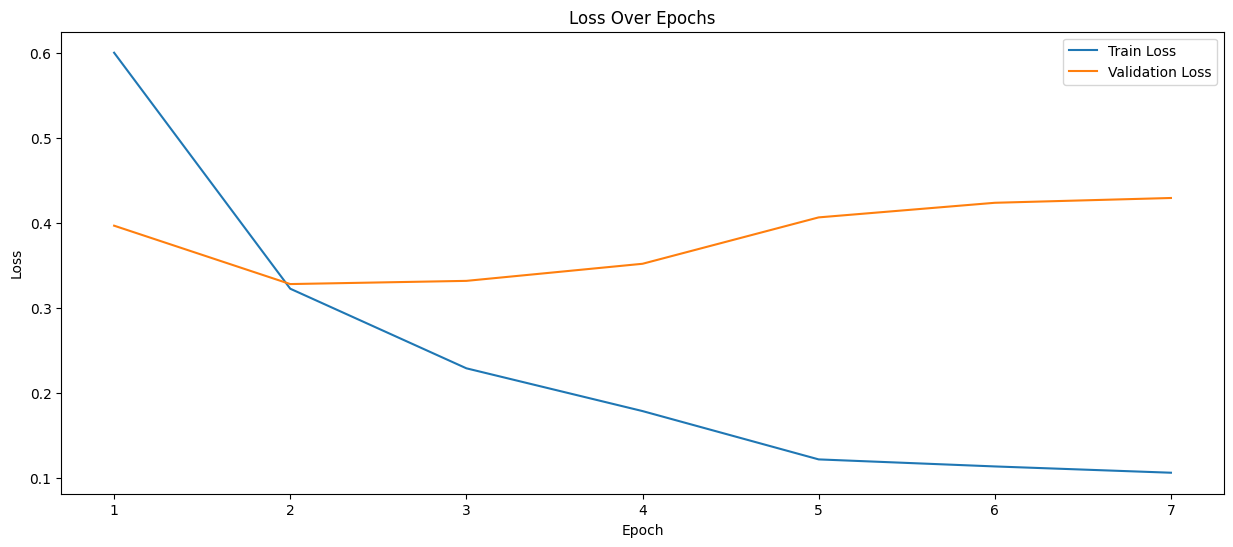

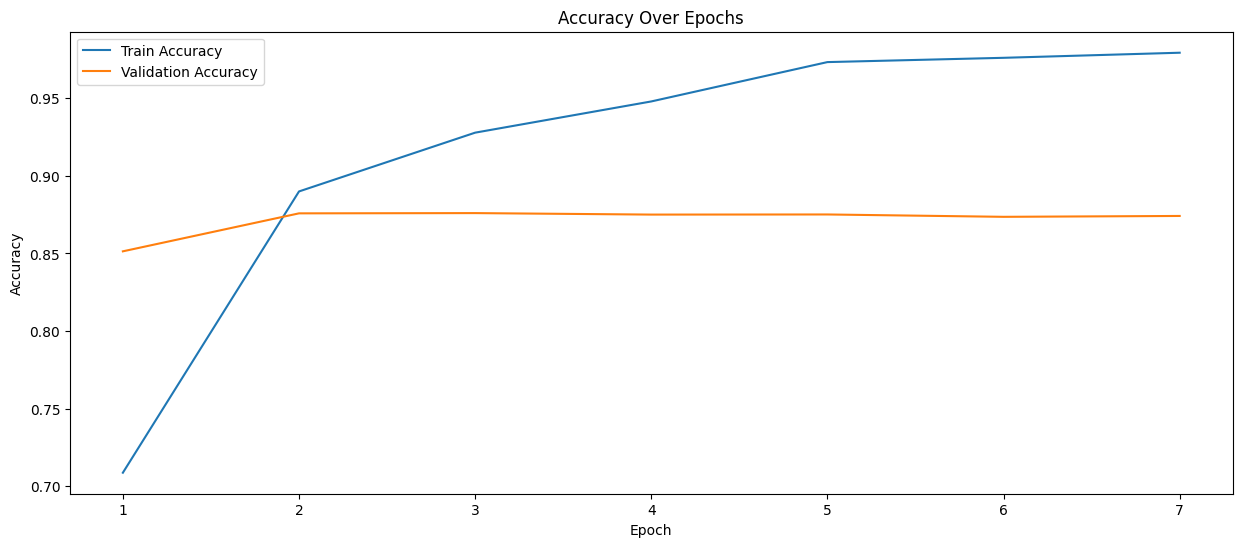

In [ ]:
# Visualize the training history
plot_training_history(lstm_best_history)

In [ ]:
# Get metrics
lstm_df_best = get_model_metrics(lstm_best, X_val_pad, y_val, model_type="dl")
lstm_df_best

391/391 [==============================] - 5s 13ms/step


,Score
Accuracy,0.875840
Precision,0.864412
Recall,0.891520
F1 Score,0.877757
ROC-AUC,0.947245


# Model Selection

In [ ]:
# Create a dictionary of metrics DataFrames
tuned_metrics_dict = {
    "RF": rf_df_best,
    "SVM": svm_df_best,
    "CNN": cnn_df_best,
    "LSTM": lstm_df_best
}

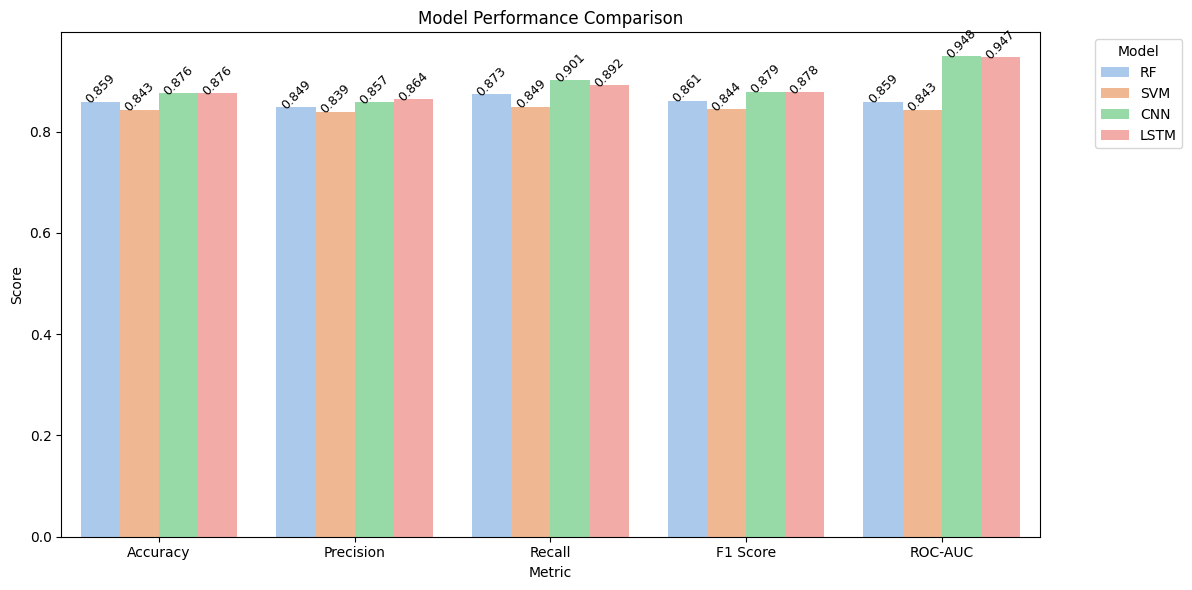

In [ ]:
# Create plots to compare
compare_model_performance(tuned_metrics_dict)

In [ ]:
# Create metrics DataFrames for test set
rf_df_test = get_model_metrics(rf_best, X_test_bow, y_test, model_type="ml")
svm_df_test = get_model_metrics(svm_best, X_test_tfidf_svd, y_test, model_type="ml")
cnn_df_test = get_model_metrics(cnn_best, X_test_pad, y_test, model_type="dl")
lstm_df_test = get_model_metrics(lstm_best, X_test_pad, y_test, model_type="dl")

391/391 [==============================] - 5s 13ms/step


In [ ]:
# Create a dictionary of DataFrames for test set
test_metrics_dict = {
    "RF": rf_df_test,
    "SVM": svm_df_test,
    "CNN": cnn_df_test,
    "LSTM": lstm_df_test
}

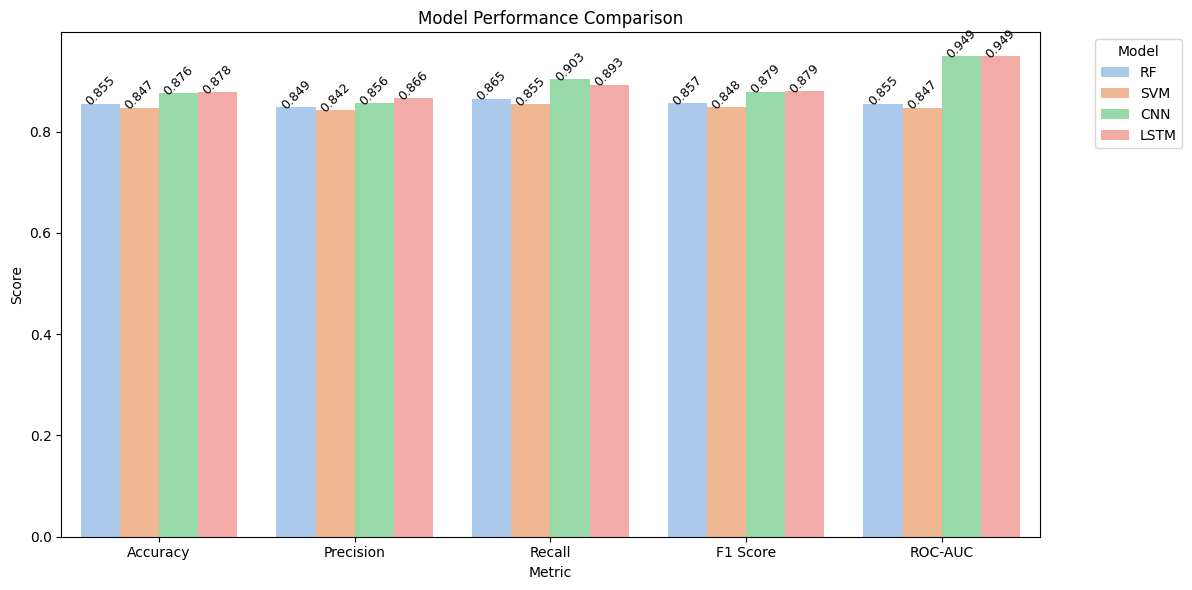

In [ ]:
# Create plots to compare
compare_model_performance(test_metrics_dict)

In [ ]:
# Save the best model
lstm_best.save("best_lstm_model.tf")

In [ ]:
# # Download the best model
# from google.colab import files

# !zip -r /content/best_lstm_model.zip /content/best_lstm_model.tf
# files.download("/content/best_lstm_model.zip")

# Sentiment Prediction

In [ ]:
# Create new review
new_review = "This movie was fantastic! I loved it."

In [ ]:
from keras.preprocessing.text import text_to_word_sequence

# Function to preprocess the new review
def preprocess_review(review, maxlen=maxlen, word_index=keras.datasets.imdb.get_word_index(), num_words=num_words):
    # Tokenize the review
    tokens = text_to_word_sequence(review)

    # Convert words to indices based on the loaded word index
    # Shift the indices by 3 and respect the num_words limit
    indexed_review = []
    for word in tokens:
        index = word_index.get(word)
        if index is not None and index < num_words:
            indexed_review.append(index + 3)
        else:
            # Use 2 for unknown words
            indexed_review.append(2)

    # Pad or truncate the sequence
    padded_review = pad_sequences([indexed_review], maxlen=maxlen, truncating="post", padding="post")

    return padded_review

In [ ]:
# Preprocess for each model
new_review_bow = vectorizer_bow.transform([new_review]).toarray()
new_review_tfidf = vectorizer_tfidf.transform([new_review])
new_review_tfidf_svd = svd.transform(new_review_tfidf)
new_review_padded = preprocess_review(new_review)

In [ ]:
# Predict with each model
sentiment_rf = rf_best.predict(new_review_bow)[0]
sentiment_svm = svm_best.predict(new_review_tfidf_svd)[0]
sentiment_cnn = (cnn_best.predict(new_review_padded) > 0.5).astype("int32")[0, 0]
sentiment_lstm = (lstm_best.predict(new_review_padded) > 0.5).astype("int32")[0, 0]

1/1 [==============================] - 0s 30ms/step


In [ ]:
# Function to convert predictions to class names
def get_class_name(prediction):
    class_name = "Positive Sentiment" if prediction == 1 else "Negative Sentiment"
    return class_name

In [ ]:
# Print predictions with class names
print(f"RF Prediction: {get_class_name(sentiment_rf)}\n")
print(f"SVM Prediction: {get_class_name(sentiment_svm)}\n")
print(f"CNN Prediction: {get_class_name(sentiment_cnn)}\n")
print(f"LSTM Prediction: {get_class_name(sentiment_lstm)}")

RF Prediction: Positive Sentiment

SVM Prediction: Positive Sentiment

CNN Prediction: Positive Sentiment

LSTM Prediction: Positive Sentiment


# Misclassification Analysis

In [ ]:
# Function to identify misclassified reviews
def identify_misclassified_reviews(model, X_test, y_test, word_index):
    # Predict sentiments for the test set
    predicted_sentiments = (model.predict(X_test) > 0.5).astype("int32").flatten()

    # Initialize DataFrame to store misclassified reviews
    misclassified_reviews = []

    # Create a reverse word index
    reverse_word_index = {idx: word for word, idx in word_index.items()}

    # Iterate over the test set and compare predictions with actual labels
    for i in range(len(X_test)):
        if predicted_sentiments[i] != y_test[i]:
            # Decode the review from index to text
            review_text = ' '.join([reverse_word_index.get(idx - 3, '?') for idx in X_test[i] if idx > 2])
            # Append misclassified review
            misclassified_reviews.append({
                "review": review_text,
                "predicted": "Positive" if predicted_sentiments[i] == 1 else "Negative",
                "actual": "Positive" if y_test[i] == 1 else "Negative"
            })

    # Convert to DataFrame
    misclassified_df = pd.DataFrame(misclassified_reviews)

    return misclassified_df

In [ ]:
# Apply the function
misclassified_reviews = identify_misclassified_reviews(lstm_best, X_test_pad, y_test, word_index)

391/391 [==============================] - 5s 14ms/step


In [ ]:
# Print some misclassified reviews
for index, row in misclassified_reviews.head(5).iterrows():
    print(f"Review: {row['review']}\nPredicted: {row['predicted']}, Actual: {row['actual']}\n")

Review: said an undercover cop from the state capital is sent to a small county where running is rampant he ends up getting run off the road by some local who have no idea he's an undercover cop so they just drive away as dopey as ever he is soon being taken care of by a woman and her three daughters who all wear low cut tops and short shorts gotta the '70s he falls in love with one of the girls but in the meantime he still has to find out who's making all the and driving it to all the local bars and he also has to with a fat sheriff and his incompetent deputy who think he's the 'cause he's new in town br br life in small town america 70s style
Predicted: Positive, Actual: Negative

Review: count me as being one who is happy to see no in this episode the poor man's dr watson does nothing for me as he simply drags down every scene he's in is often necessary to the story as the representative of and a little miss is fine for but from painfully dim to over mannered in different episodes i

## Confusion Matrix

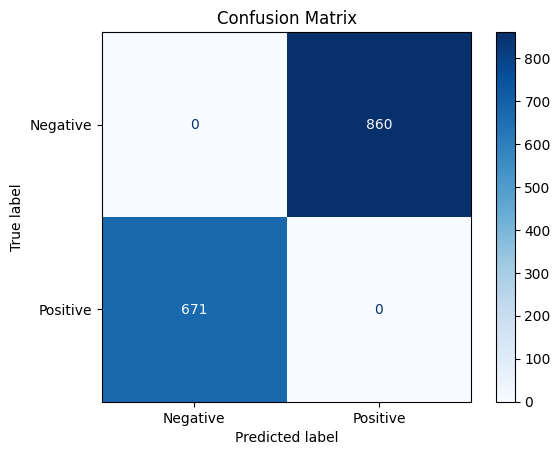

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Extract actual and predicted
actual = misclassified_reviews["actual"]
predicted = misclassified_reviews["predicted"]

# Create the confusion matrix
cm = confusion_matrix(actual, predicted)

# Plotting
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Negative", "Positive"])

disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

## Topic Modeling

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

# Vectorize the reviews
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words="english")
dtm = vectorizer.fit_transform(misclassified_reviews["review"])

# Apply LDA
lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(dtm)

# Function to display the topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("\n")

# Use the function
display_topics(lda, vectorizer.get_feature_names_out(), 10)

Topic 0:
film like br man films movie story just people good


Topic 1:
br film movie life good mother time characters scenes does


Topic 2:
movie film like br good just people time funny make


Topic 3:
br movie film like just good really time don people


Topic 4:
movie film like good bad time just better story think




## Sentiment Intensity

In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download the VADER lexicon
nltk.download("vader_lexicon")

# Create SIA instance
sia = SentimentIntensityAnalyzer()

# Calculate sentiment scores
misclassified_reviews["sentiment_score"] = misclassified_reviews["review"].apply(lambda x: sia.polarity_scores(x)["compound"])

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


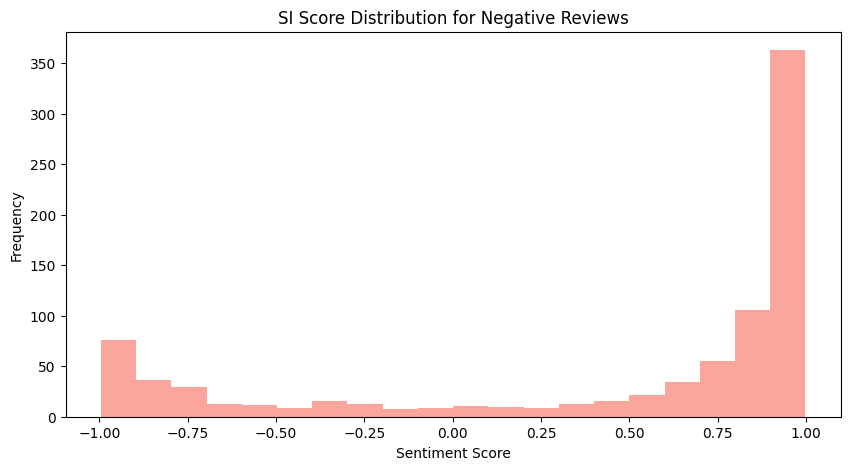

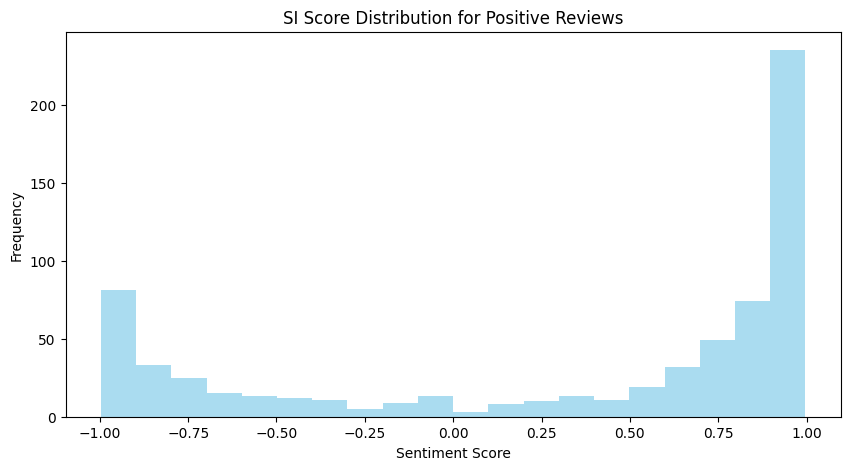

In [ ]:
# Plot for negative reviews
plt.figure(figsize=(10, 5))
plt.hist(misclassified_reviews[misclassified_reviews["actual"] == "Negative"]["sentiment_score"], bins=20, alpha=0.7, color="salmon")
plt.title("SI Score Distribution for Negative Reviews")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()

# Plot for positive reviews
plt.figure(figsize=(10, 5))
plt.hist(misclassified_reviews[misclassified_reviews["actual"] == "Positive"]["sentiment_score"], bins=20, alpha=0.7, color="skyblue")
plt.title("SI Score Distribution for Positive Reviews")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()

## Length & Complexity

In [ ]:
!pip install textstat -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 66.1 MB/s eta 0:00:00


In [ ]:
import textstat

# Length of reviews
misclassified_reviews["review_length"] = misclassified_reviews["review"].apply(len)

# Complexity of reviews
misclassified_reviews["readability"] = misclassified_reviews["review"].apply(textstat.flesch_reading_ease)

# Display the results
print(misclassified_reviews.groupby("actual")["review_length"].mean())
print("\n")
print(misclassified_reviews.groupby("actual")["readability"].mean())

actual
Negative    941.244186
Positive    800.517139
Name: review_length, dtype: float64


actual
Negative   -88.944558
Positive   -61.966438
Name: readability, dtype: float64


## Threshold Optimization

In [ ]:
# Get predictions
raw_predictions = lstm_best.predict(X_test_pad).ravel()

# Set thresholds
thresholds = np.linspace(0.25, 0.75, num=100)
scores = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": []
}

# Loop through the thresholds
for threshold in thresholds:
    # Convert probabilities to binary predictions
    binary_predictions = (raw_predictions > threshold).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, binary_predictions)
    precision = precision_score(y_test, binary_predictions)
    recall = recall_score(y_test, binary_predictions)
    f1 = f1_score(y_test, binary_predictions)

    # Append metrics to the lists
    scores["accuracy"].append(accuracy)
    scores["precision"].append(precision)
    scores["recall"].append(recall)
    scores["f1"].append(f1)

391/391 [==============================] - 5s 14ms/step


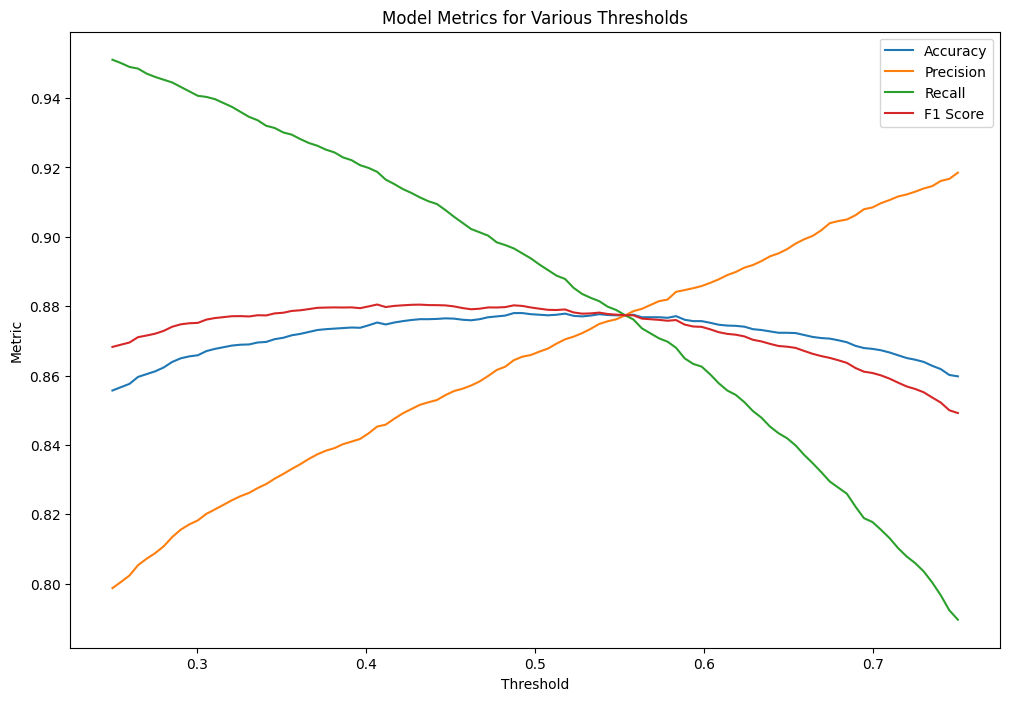

In [ ]:
# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(thresholds, scores["accuracy"], label="Accuracy")
plt.plot(thresholds, scores["precision"], label="Precision")
plt.plot(thresholds, scores["recall"], label="Recall")
plt.plot(thresholds, scores["f1"], label="F1 Score")
plt.title("Model Metrics for Various Thresholds")
plt.xlabel("Threshold")
plt.ylabel("Metric")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc

# Get fpr, tpr, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, raw_predictions)
roc_auc = auc(fpr, tpr)

# Find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold based on ROC-AUC: {optimal_threshold}")

Optimal Threshold based on ROC-AUC: 0.492045134305954


In [ ]:
from sklearn.metrics import precision_recall_curve

# Get precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, raw_predictions)

# Add the end point for the thresholds array
thresholds = np.append(thresholds, 1)

# Calculate F1 scores for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Find the index of the maximum F1 score
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold based on F1 score: {optimal_threshold}")

Optimal Threshold based on F1 score: 0.43425849080085754


In [ ]:
# Get precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, raw_predictions)

# Define the minimum acceptable recall
min_acceptable_recall = 0.85

# Filter out thresholds where recall is below acceptable level
acceptable_precision_recall = [(p, r, t) for p, r, t in zip(precision, recall, thresholds) if r >= min_acceptable_recall]

# Sort by precision in descending order
sorted_by_precision = sorted(acceptable_precision_recall, key=lambda x: x[0], reverse=True)

# Get the threshold with the highest precision
optimal_precision, optimal_recall, optimal_threshold = sorted_by_precision[0]

print(f"Optimal Threshold for max precision with at least {min_acceptable_recall} recall: {optimal_threshold}")

Optimal Threshold for max precision with at least 0.85 recall: 0.6285715699195862


# App Prototyping

In [ ]:
# import zipfile
# import os

# # Unzip the uploaded file
# zip_path = "/best_lstm_model.zip"
# extract_path = "/content"

# with zipfile.ZipFile(zip_path, "r") as zip_ref:
#     zip_ref.extractall(extract_path)

# # Remove zip file after extraction
# os.remove(zip_path)

In [ ]:
# Load the model
model_path = "/content/best_lstm_model.tf"
model = models.load_model(model_path)

In [ ]:
from keras.preprocessing.text import text_to_word_sequence

# Function to preprocess the new review
def preprocess_review(review, maxlen=maxlen, word_index=keras.datasets.imdb.get_word_index(), num_words=num_words):
    # Tokenize the review
    tokens = text_to_word_sequence(review)

    # Convert words to indices based on the loaded word index
    indexed_review = []
    for word in tokens:
        index = word_index.get(word)
        if index is not None and index < num_words:
            indexed_review.append(index + 3)
        else:
            # Use 2 for unknown words
            indexed_review.append(2)

    # Pad or truncate the sequence
    padded_review = pad_sequences([indexed_review], maxlen=maxlen, truncating="post", padding="post")

    return padded_review

In [ ]:
# Function to get sentiment prediction
def predict_sentiment(review):
    try:
        processed_review = preprocess_review(review)
        prediction = model.predict(processed_review)
        print(f"Raw Prediction: {prediction}")
        sentiment = "Positive" if prediction[0][0] > 0.6285715699195862 else "Negative"
        return sentiment
    except Exception as e:
        print(f"Error in prediction: {e}")
        raise e

In [ ]:
# Test the sentiment prediction
review = "The movie was not what I was expecting. It was a bit too long. The characters were lame. I won't ever see this movie again. I don't recommend it to anyone."

predict_sentiment(review)

1/1 [==============================] - 0s 37ms/step
Raw Prediction: [[0.58328456]]


'Negative'

In [ ]:
!pip install flask flask-ngrok pyngrok -q

In [ ]:
# Define HTML template
html_template = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Sentiment Analysis</title>
    <style>
        body {
            font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif;
            background-color: #f7f7f7;
            margin: 0;
            padding: 0;
            display: flex;
            justify-content: center;
            align-items: center;
            height: 100vh;
        }
        .container {
            background-color: #fff;
            padding: 40px;
            border-radius: 10px;
            box-shadow: 0 4px 6px rgba(0,0,0,0.1);
            width: 100%;
            max-width: 400px;
            margin: 0 20px;
            text-align: center;
        }
        h1 {
            color: #333;
            margin-bottom: 40px;
        }
        textarea {
            width: calc(100% - 20px);
            padding: 10px;
            margin-bottom: 20px;
            border: 1px solid #ddd;
            border-radius: 5px;
            height: 100px;
            resize: vertical;
        }
        .button {
            background-color: #5cb85c;
            color: white;
            padding: 10px 20px;
            margin: 20px 0;
            border: none;
            border-radius: 5px;
            cursor: pointer;
            font-size: 18px;
            width: 100%;
            box-shadow: 0 2px 4px rgba(0,0,0,0.2);
            transition: background-color 0.3s ease;
        }
        .button:hover {
            background-color: #4cae4c;
        }
        .result {
            margin-top: 20px;
            padding: 20px;
            background-color: #f1f1f1;
            border-radius: 5px;
        }
        .result h3 {
            margin: 0;
            color: #333;
        }
    </style>
</head>
<body>
    <div class="container">
        <h1>Sentiment Analyzer</h1>
        <form action="/" method="post">
            <textarea name="review" placeholder="Enter your movie review here..."></textarea>
            <button type="submit" class="button">Analyze Sentiment</button>
        </form>
        {% if sentiment %}
            <div class="result">
                <h3>Sentiment: {{ sentiment }} {% if sentiment == "Positive" %}😊{% else %}😞{% endif %}</h3>
            </div>
        {% endif %}
    </div>
</body>
</html>
"""

In [ ]:
from flask import Flask, request, render_template_string
from pyngrok import ngrok
import os
import threading

# Initialize Flask app
app = Flask(__name__)

@app.route("/", methods=["GET", "POST"])
def index():
    sentiment = None
    if request.method == "POST":
        review = request.form["review"]
        sentiment = predict_sentiment(review)
        print(f"Predicted Sentiment: {sentiment}")
    return render_template_string(html_template, sentiment=sentiment)

if __name__ == "__main__":
    port = 5000
    ngrok_tunnel = ngrok.connect(port)
    print(f" * ngrok tunnel \"{ngrok_tunnel.public_url}\" -> \"http://127.0.0.1:{port}\"")

    app.run(port=port)